In [21]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from TO_sim.Sol_Kuramoto import Sol_Kuramoto_mK as mK
from TO_sim.Sol_Kuramoto import Sol_Kuramoto_mf2 as mf2
from TO_sim.Get_groups import phase_diagram,make_meanr

from TO_sim.gen_Distribution import Normal
from TO_sim.gen_Distribution import Quantile_Normal as Q_Normal
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from tqdm.notebook import tqdm
from scipy.signal import find_peaks
import parmap
from pprint import pprint

In [2]:
seed =10
N = 1000
theta_random,omega,Kc = Q_Normal(N,0,1,seed=seed)

omega = omega - np.mean(omega)
omega = np.sort(omega)
m = 5
dt = 0.1
t = np.arange(0,5000,dt)
K = 7
to_ppi = lambda y: (y + np.pi)%(2*np.pi) - np.pi
theta, dtheta,rs = mf2(K,N=N,m=m,t_array=t,p_theta=theta_random,p_dtheta=omega,p_omega=omega)
# plt.plot(np.sort(avg_dtheta[-1]))
# plt.plot((avg_dtheta[-1]))

In [3]:
new_theta = to_ppi(theta)
dtheta_c = np.cumsum(dtheta,axis=0)
sum_time = 200
avg_dtheta = (dtheta_c[sum_time:]-dtheta_c[:-sum_time])/sum_time

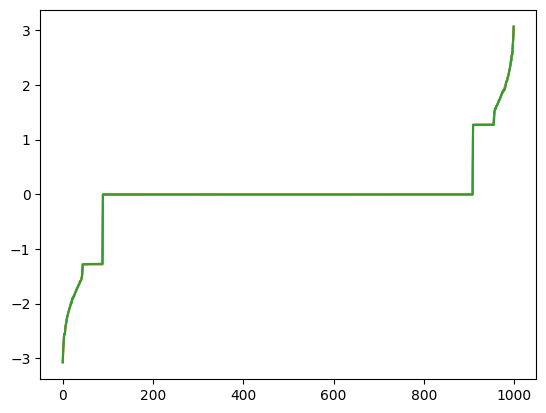

In [4]:
ARG = (theta[-1]-theta[-len(t)//4])//np.pi
ARD = (theta[-1]-theta[-len(t)//4])/(len(t)//4 -1)/dt

# plt.plot(ARG)
plt.plot(ARD)
ARG = (theta[-1]-theta[-len(t)//8])//np.pi
ARD = (theta[-1]-theta[-len(t)//8])/(len(t)//8 -1)/dt
plt.plot(ARD)
plt.plot(avg_dtheta[-1])

In [5]:
import TO_sim.analytical.sec_order_parameter2 as OSP2
import TO_sim.Q_simul as QSIM

In [6]:
Qsimul = QSIM.Q_Norm_simul(N,K=K,m = m,t_end=10000,start_p=True,seed=6)

In [7]:
Qsimul = QSIM.Q_Norm_simul(N,K=K,m = m,t_end=2000,start_p=True,seed=6)
sol = Qsimul.solve()
omega = Qsimul.omega

In [8]:
# N = 2000
# K = 5.7
%timeit sol = Qsimul.solve()

1.68 s ± 177 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
ARG = (theta[-1]-theta[-5000])//np.pi
ARG =  np.where(ARG<0,ARG,ARG+1)
u,c = np.unique(ARG,return_counts=True)

I_c_o1 =np.where(c>1)
u_o1 = u[I_c_o1]
c_o1 = c[I_c_o1]
u_c = np.argsort(c_o1)[::-1]
UU = u_o1[u_c]


In [10]:
def Get_Group(TH_s,TH_e,L,dt):
    ARG = (TH_s-TH_e)//np.pi
    ARG =  np.where(ARG<0,ARG,ARG)
    u,c = np.unique(ARG,return_counts=True)

    I_c_o1 =np.where(c>5)
    u_o1 = u[I_c_o1]
    c_o1 = c[I_c_o1]
    u_c = np.argsort(c_o1)[::-1]
    UU = u_o1[u_c]

    arr = UU
    main_value = np.min(abs(arr))
    adjusted_arr = arr - main_value
    abs_arr = np.unique(np.abs(adjusted_arr))
    abs_arr
    group_threshold = 5
    G = {}
    GP = {}
    GM = {}
    GN = {}
    G_num = 0
    GP_num = 1
    GM_num = 1
    I_num = 1
    for i in range(1,5):
        GP[i,'I'] = []
        GP[i,'R'] = np.nan
        GP[i,'L'] = np.nan
        GP[i,'V'] = np.nan
        GM[i,'I'] = []
        GM[i,'R'] = np.nan
        GM[i,'L'] = np.nan
        GM[i,'V'] = np.nan
    for i in range(5):
        abs_arr = np.unique(np.abs(adjusted_arr))
        for num in abs_arr:
            abs_adjust_arr = np.abs(adjusted_arr)
            in_group = np.int64(np.round((abs_adjust_arr-num)/group_threshold)) * group_threshold
            is_group = np.where(abs(in_group) < 1)
            not_group = np.where(in_group >= 1)
            if len(is_group) != 0:
                Ra_arr = adjusted_arr[is_group]
                R = Ra_arr + main_value
                if G_num == 0:
                    I, = np.where(np.isin(ARG,R))
                    G[G_num,'I'] = I
                    G[G_num,'R'] = R
                    G[G_num,'L'] = len(I)
                    G[G_num,'V'] = np.mean(R/(L-1)/dt)
                    G_num +=1
                else:
                    gp_idx, = np.where(Ra_arr>0)
                    gm_idx, = np.where(Ra_arr<0)
                    Rp = R[gp_idx]
                    Rm = R[gm_idx]
                    Ip, = np.where(np.isin(ARG,Rp))
                    Im, = np.where(np.isin(ARG,Rm))
                    if (len(Rp) !=0) and (len(Rm) != 0):
                        GM[GM_num,'I'] = Im
                        GM[GM_num,'R'] = Rm
                        GM[GM_num,'V'] = np.mean(Rm/(L-1)/dt)
                        GM[GM_num,'L'] = len(Im)
                        GP[GP_num,'I'] = Ip
                        GP[GP_num,'R'] = Rp
                        GP[GP_num,'V'] = np.mean(Rp/(L-1)/dt)
                        GP[GP_num,'L'] = len(Ip)
                        GP_num += 1
                        GM_num += 1
                    elif (len(Rp) !=0):
                        GP[GP_num,'I'] = Ip
                        GP[GP_num,'R'] = Rp
                        GP[GP_num,'L'] = len(Ip)
                        GP[GP_num,'V'] = np.mean(Rp/(L-1)/dt)

                        GP_num += 1
                    else:
                        GM[GM_num,'I'] = Im
                        GM[GM_num,'R'] = Rm
                        GM[GM_num,'L'] = len(Im)
                        GM[GM_num,'V'] = np.mean(Rm/(L-1)/dt)

                        GM_num += 1

            adjusted_arr = adjusted_arr[not_group]
            break
    return G,GM,GP

In [11]:
TH = 2000
TH_S,TH_E,L = theta[-1],theta[-TH],TH
G,GM,GP = Get_Group(TH_S,TH_E,L,dt =dt)

In [12]:
GM[2,'L']/GM[1,'L'],GP[2,'L']/GP[1,'L']

(nan, nan)

In [13]:
GM[1,'L']/G[0,'L'],GP[1,'L']/G[0,'L']

(0.054878048780487805, 0.05731707317073171)

In [14]:
GM[2,'L']/G[0,'L'],GP[2,'L']/G[0,'L']

(nan, nan)

In [15]:
G[0,'V']

-0.005002501250625312

In [16]:
(GM[1,'V']-G[0,'V'])/G[0,'V'],(GP[1,'V']-G[0,'V'])/G[0,'V']

(81.0, -82.0)

In [579]:
arr = UU
main_value = np.min(abs(arr))
adjusted_arr = arr - main_value
print(main_value)
abs_arr = np.unique(np.abs(adjusted_arr))
abs_arr

1.0


array([  2., 204., 207., 305., 308., 408., 411.])

In [580]:
np.unique(adjusted_arr)

array([-411., -308., -207.,   -2.,  204.,  305.,  408.])

In [581]:
# ARGs = []
# for i in range(len(t)-400):
#     A = (theta[400+i]-theta[i])//np.pi
#     A_m  = A - A[np.argmin(np.abs(A))]
#     ARGs.append(A_m)
# # ARGs = [(theta[5000+i]-theta[i])//np.pi - np.abs(theta[5000+i]-theta[i])//np.pi) for i in range(len(t)-5000)]

In [18]:
GL = np.max(omega[G['0','I']]) - np.min(omega[G['0','I']])
GPL = np.max(omega[GP['1','I']]) - np.min(omega[GP['1','I']]) 
GML = np.max(omega[GM['1','I']]) - np.min(omega[GM['1','I']])

GPL2 = np.max(omega[GP['2','I']]) - np.min(omega[GP['2','I']]) 
GML2 = np.max(omega[GM['2','I']]) - np.min(omega[GM['2','I']])

KeyError: ('0', 'I')

In [583]:
GPL / GL,GML / GL

(0.13905681871428702, 0.1344458415154452)

In [584]:
GPL / GL,GML / GL

(0.13905681871428702, 0.1344458415154452)

In [585]:
GPL2/GL

2.3146517784216885

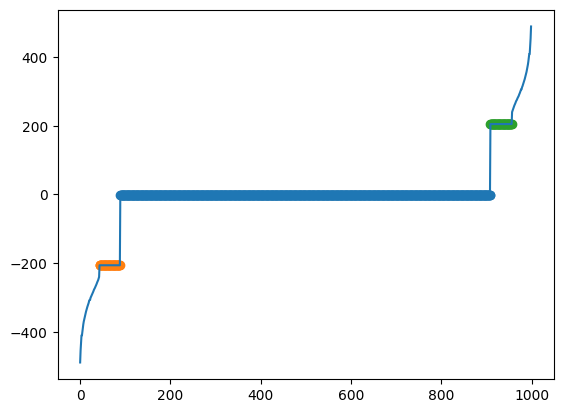

In [586]:
plt.plot(ARG)
plt.scatter(G[0,'I'],ARG[G[0,'I']])
plt.scatter(GM[1,'I'],ARG[GM[1,'I']])
plt.scatter(GP[1,'I'],ARG[GP[1,'I']])
plt.scatter(GM[2,'I'],ARG[GM[2,'I']])
plt.scatter(GP[2,'I'],ARG[GP[2,'I']])


# plt.scatter(GM[3,'I'],ARG[GM[3,'I']])
# plt.scatter(GP[3,'I'],ARG[GP[3,'I']])
# plt.scatter(GM[3,'I'],ARG[GM[3,'I']])
# plt.scatter(GP[3,'I'],ARG[GP[3,'I']])

In [556]:
omega[[]]

array([], dtype=float64)

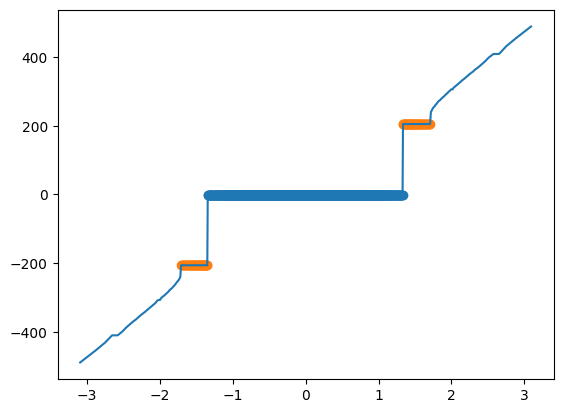

In [571]:
plt.plot(omega,ARG)
plt.scatter(omega[G[0,'I']],ARG[G[0,'I']])
plt.scatter(omega[GM[1,'I']],ARG[GM[1,'I']],color='tab:orange')
plt.scatter(omega[GP[1,'I']],ARG[GP[1,'I']],color='tab:orange')
plt.scatter(omega[GM[2,'I']],ARG[GM[2,'I']],color= 'tab:green')
plt.scatter(omega[GP[2,'I']],ARG[GP[2,'I']],color= 'tab:green')
# plt.scatter(omega[GM[3,'I']],ARG[GM[3,'I']],color= 'tab:red')
# plt.scatter(omega[GP[3,'I']],ARG[GP[3,'I']],color= 'tab:red')


# plt.scatter(omega[GM[4,'I']],ARG[GM[4,'I']])
# plt.scatter(omega[GP[4,'I']],ARG[GP[4,'I']])

In [307]:
def get_TM(x,step):
    x_c = np.cumsum(x,axis=0)
    if x.ndim == 2:
        x_m = (x_c[step:,:] - x_c[:-step,:])/step
    else:
        x_m = (x_c[step:] - x_c[:-step])/step
    return x_m

In [394]:
STEP =  100
ET = get_TM(theta,STEP)

In [395]:
r = np.sum(np.exp(1j*theta[:,]),axis=1)/N
rm = np.sum(np.exp(1j*ET[:,]),axis=1)/N
sigma = np.array([np.std(r[i:i+STEP]) for i in range(len(t)-STEP)])

In [396]:
r = np.sum(np.exp(1j*theta[:,]),axis=1)/N
r0 = np.sum(np.exp(1j*theta[:,G[0,'I']]),axis=1)/N
r1m = np.zeros_like(r0)* np.nan
r1p = np.zeros_like(r0)* np.nan
r2m = np.zeros_like(r0)* np.nan
r2p = np.zeros_like(r0)* np.nan

if GP_num >=3:
    r1m = np.sum(np.exp(1j*theta[:,GM[1,'I']]),axis=1)/N
    r1p = np.sum(np.exp(1j*theta[:,GP[1,'I']]),axis=1)/N
    r2m = np.sum(np.exp(1j*theta[:,GM[2,'I']]),axis=1)/N
    r2p = np.sum(np.exp(1j*theta[:,GP[2,'I']]),axis=1)/N
elif GP_num ==2:
    r1m = np.sum(np.exp(1j*theta[:,GM[1,'I']]),axis=1)/N
    r1p = np.sum(np.exp(1j*theta[:,GP[1,'I']]),axis=1)/N

KeyError: (2, 'I')

In [ ]:

r0 = np.mean(np.exp(1j*ET[:,G[0,'I']]),axis=1)
r1m = np.zeros_like(r0)* np.nan
r1p = np.zeros_like(r0)* np.nan
r2m = np.zeros_like(r0)* np.nan
r2p = np.zeros_like(r0)* np.nan

if GP_num ==3:
    r1m = np.mean(np.exp(1j*ET[:,GM[1,'I']]),axis=1)
    r1p = np.mean(np.exp(1j*ET[:,GP[1,'I']]),axis=1)
    r2m = np.mean(np.exp(1j*ET[:,GM[2,'I']]),axis=1)
    r2p = np.mean(np.exp(1j*ET[:,GP[2,'I']]),axis=1)
elif GP_num >=4:
    r1m = np.mean(np.exp(1j*ET[:,GM[1,'I']]),axis=1)
    r1p = np.mean(np.exp(1j*ET[:,GP[1,'I']]),axis=1)
    r2m = np.mean(np.exp(1j*ET[:,GM[2,'I']]),axis=1)
    r2p = np.mean(np.exp(1j*ET[:,GP[2,'I']]),axis=1)
    r3m = np.mean(np.exp(1j*ET[:,GM[3,'I']]),axis=1)
    r3p = np.mean(np.exp(1j*ET[:,GP[3,'I']]),axis=1)
elif GP_num ==2:
    r1m = np.mean(np.exp(1j*ET[:,GM[1,'I']]),axis=1)
    r1p = np.mean(np.exp(1j*ET[:,GP[1,'I']]),axis=1)

In [ ]:
r2p.shape

(49999,)

In [ ]:
tm = get_TM(t,STEP)
# r0m = get_TM(r0,10)

ValueError: x and y must have same first dimension, but have shapes (49900,) and (99900,)

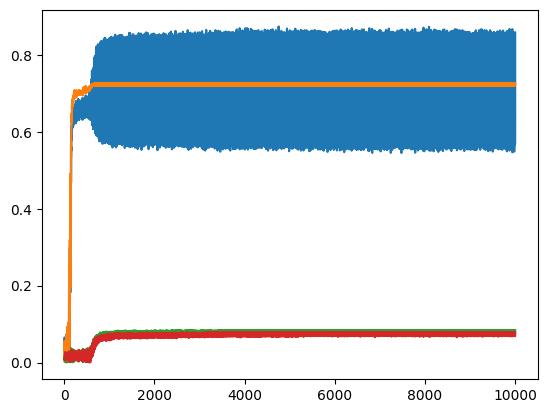

In [397]:
plt.plot(t,abs(r))
plt.plot(t,abs(r0))
plt.plot(t,abs(r1m))
plt.plot(t,abs(r1p))

plt.plot(tm,sigma)
plt.plot(t,abs(r2m))
plt.plot(t,abs(r2p))

# plt.plot(t,abs(r3m))
# plt.plot(t,abs(r3p))

In [22]:
STEP =  1000
EDT = get_TM(dtheta,STEP)

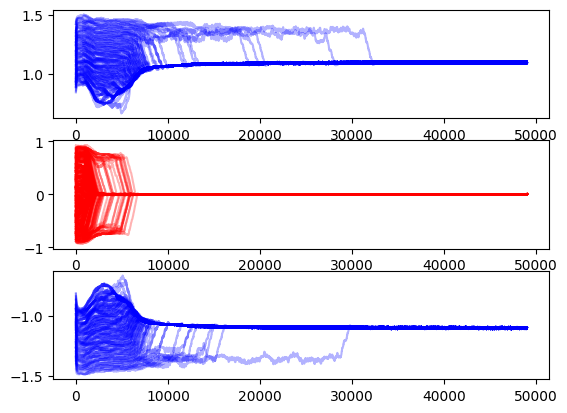

In [24]:
plt.subplot(311)
plt.plot(EDT[:,GP[1,'I']],color='blue',alpha=0.3);

plt.subplot(312)
plt.plot(EDT[:,G[0,'I']],color='red',alpha=0.3);
plt.subplot(313)
plt.plot(EDT[:,GM[1,'I']],color='blue',alpha=0.3);

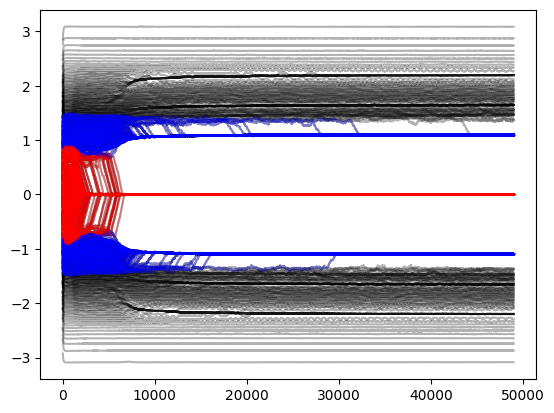

In [23]:
plt.plot(EDT,color='black',alpha=0.3);
plt.plot(EDT[:,G[0,'I']],color='red',alpha=0.3);
plt.plot(EDT[:,GP[1,'I']],color='blue',alpha=0.3);
plt.plot(EDT[:,GM[1,'I']],color='blue',alpha=0.3);
plt.show()

# 이론 그래프

In [194]:
import TO_sim.analytical.order_sec_parameter as OSP

In [214]:
m = 1
F_RMd2,F_RMu2,F_R0d2,F_R0u2 =  OSP.Make_R_function(m)

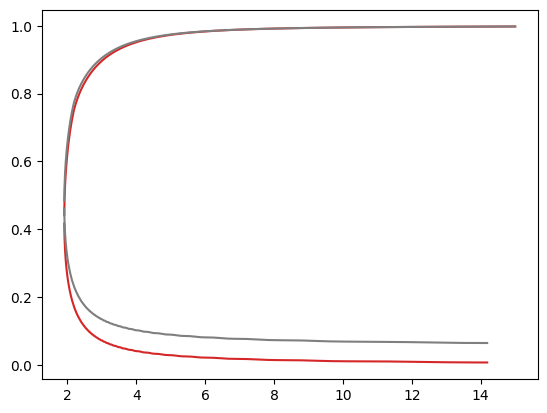

In [215]:
K_ = np.linspace(0,15,10000)

plt.plot(K_,F_RMd2(K_),color='tab:red')
plt.plot(K_,F_RMu2(K_),color='tab:red')

plt.plot(K_,F_R0d2(K_),color='tab:grey')
plt.plot(K_,F_R0u2(K_),color='tab:grey')


0.02

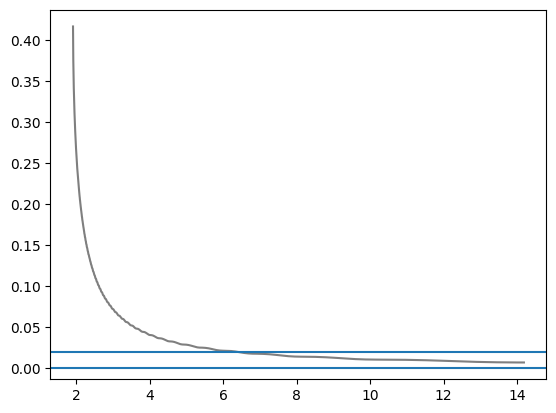

In [217]:
plt.plot(K_,F_RMd2(K_),color='tab:grey')
plt.plot(K_,F_RMd2(K_),color='tab:grey')
plt.axhline(0)
plt.axhline(0.02)
np.sqrt(2/N)

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from TO_sim.Sol_Kuramoto import Sol_Kuramoto_mf2 as mf2
from TO_sim.Kuramoto_model import Kuramoto_2nd_mf,Kuramoto_1st_mf
from scipy.stats import norm
from TO_sim.get_cluster import cluster_os_new2
from TO_sim.gen_Distribution import Normal, Quantile_Normal as Q_Normal, Lorentzian
import TO_sim.analytical.order_sec_parameter as OSP
import TO_sim.analytical.sec_order_parameter2 as OSP2
import TO_sim.Integrator_jit as IJ
from tqdm.notebook import tqdm

RK4_jit = IJ.RK4
RK4_jit_short = IJ.RK4_short


class Q_Norm_simul():
    def __init__(self,N,K,m,dt = 0.1,t_end = 5000,seed = 10,start_p = False,g_n=None) -> None:
        '''input : N,K,m,dt. dt, t_end,seed'''
        self.seed = seed
        theta_random, omega, Kc = Q_Normal(N, 0, 1, seed=seed)
        if g_n!=None:
            dist = np.linspace(0,1,N+2)[1:-1]
            omega = g_n(dist)
        omega = np.sort(omega)-np.mean(omega)
        self.N = N; self.K = K; self.m = m;self.dt = dt
        self.t_end = t_end; self.dt = dt
        self.omega = omega
        self.t = np.arange(0, self.t_end+self.dt/2, self.dt)
        Theta = np.zeros(2*N)
        Theta[:N] = theta_random 
        if start_p:
            Theta[N:2*N] = omega
        self.Theta_init = Theta
        self.Theta_ori = Theta
    def solve(self):
        t = self.t
        if self.m == 0:
            func = Kuramoto_1st_mf
        else:
            func = Kuramoto_2nd_mf
            
        sol = RK4_jit(func,self.Theta_init,t, args=(self.omega, self.N, self.m, self.K))
        self.Last_sol = sol[-1]
        N = self.N
        theta,dtheta = sol[:,:N],sol[:,N:2*N]
        rabs = np.mean(np.exp(theta.T*1j),axis=0)
        rs = np.abs(rabs)
        psi = np.angle(rabs)
        if self.dt <0.1:
            t = t[::10]
            theta = theta[::10]
            dtheta = dtheta[::10]
            rs = rs[::10]
            psic = psic[::10]
        self.rs = rs
        self.psi = psi
        self.theta = theta
        self.dtheta = dtheta
        self.Theta_last = sol[-1]
        self.r_mean = np.mean(rs[-500:])
        solution = {}
        solution['rs'] = rs
        solution['psi'] = psi
        solution['r_mean'] = self.r_mean
        solution['r_std'] = np.std(rs[-2000:])
        solution['t'] = t
        solution['theta'] = theta
        solution['dtheta'] = dtheta
        solution['Theta_last'] = sol[-1]
        return solution
    
    def solve_short(self,result_time=2010):
        t = self.t
        if self.m == 0:
            func = Kuramoto_1st_mf
        else:
            func = Kuramoto_2nd_mf
            
        sol = RK4_jit_short(func,self.Theta_init,t, args=(self.omega, self.N, self.m, self.K),result_time=result_time)
        self.Last_sol = sol[-1]
        N = self.N
        theta,dtheta = sol[:,:N],sol[:,N:2*N]
        rabs = np.mean(np.exp(theta.T*1j),axis=0)
        rs = np.abs(rabs)
        psi = np.angle(rabs)
        if self.dt <0.1:
            t = t[::10]
            theta = theta[::10]
            dtheta = dtheta[::10]
            rs = rs[::10]
            psic = psic[::10]

        self.rs = rs
        self.psi = psi
        self.theta = theta
        self.dtheta = dtheta
        self.Theta_last = sol[-1]
        self.r_mean = np.mean(rs[-500:])
        solution = {}
        solution['rs'] = rs
        solution['psi'] = psi
        solution['r_mean'] = self.r_mean
        solution['r_std'] = np.std(rs[-2000:])
        solution['t'] = t
        solution['theta'] = theta
        solution['dtheta'] = dtheta
        solution['Theta_last'] = sol[-1]
        return solution
    

    def get_Group(self,L=2000,Nc=5):
        dt = self.dt
        theta = self.theta
        ARG = (theta[-1]-theta[-L])//np.pi
        avg_dtheta = ARG/(L-1)/dt
        self.avg_dtheta = avg_dtheta
        ARG =  np.where(ARG<0,ARG,ARG)
        u,c = np.unique(ARG,return_counts=True)

        I_c_o1 =np.where(c>Nc)
        u_o1 = u[I_c_o1]
        c_o1 = c[I_c_o1]
        u_c = np.argsort(c_o1)[::-1]
        UU = u_o1[u_c]

        arr = UU
        main_value = np.min(abs(arr))
        adjusted_arr = arr - main_value
        abs_arr = np.unique(np.abs(adjusted_arr))
        abs_arr
        group_threshold = 5
        G = {}
        GP = {}
        GM = {}
        G_num = 0
        GP_num = 1
        GM_num = 1
        for i in range(1,5):
            GP[i,'I'] = [];GP[i,'R'] = np.nan;GP[i,'L'] = np.nan;GP[i,'V'] = np.nan
            GM[i,'I'] = [];GM[i,'R'] = np.nan;GM[i,'L'] = np.nan;GM[i,'V'] = np.nan
        for i in range(5):
            abs_arr = np.unique(np.abs(adjusted_arr))
            for num in abs_arr:
                abs_adjust_arr = np.abs(adjusted_arr)
                in_group = np.int64(np.round((abs_adjust_arr-num)/group_threshold)) * group_threshold
                is_group = np.where(abs(in_group) < 1)
                not_group = np.where(in_group >= 1)
                if len(is_group) != 0:
                    Ra_arr = adjusted_arr[is_group]
                    R = Ra_arr + main_value
                    if G_num == 0:
                        I, = np.where(np.isin(ARG,R))
                        G[G_num,'I'] = I
                        G[G_num,'R'] = R
                        G[G_num,'L'] = len(I)
                        G[G_num,'V'] = np.mean(R/(L-1)/dt)
                        G_num +=1
                    else:
                        gp_idx, = np.where(Ra_arr>0)
                        gm_idx, = np.where(Ra_arr<0)
                        Rp = R[gp_idx]
                        Rm = R[gm_idx]
                        Ip, = np.where(np.isin(ARG,Rp))
                        Im, = np.where(np.isin(ARG,Rm))
                        if (len(Rp) !=0) and (len(Rm) != 0):
                            GM[GM_num,'I'] = Im
                            GM[GM_num,'R'] = Rm
                            GM[GM_num,'V'] = np.mean(Rm/(L-1)/dt)
                            GM[GM_num,'L'] = len(Im)
                            GP[GP_num,'I'] = Ip
                            GP[GP_num,'R'] = Rp
                            GP[GP_num,'V'] = np.mean(Rp/(L-1)/dt)
                            GP[GP_num,'L'] = len(Ip)
                            GP_num += 1
                            GM_num += 1
                        elif (len(Rp) !=0):
                            GP[GP_num,'I'] = Ip
                            GP[GP_num,'R'] = Rp
                            GP[GP_num,'L'] = len(Ip)
                            GP[GP_num,'V'] = np.mean(Rp/(L-1)/dt)
                            GP_num += 1
                        else:
                            GM[GM_num,'I'] = Im
                            GM[GM_num,'R'] = Rm
                            GM[GM_num,'L'] = len(Im)
                            GM[GM_num,'V'] = np.mean(Rm/(L-1)/dt)
                            GM_num += 1
                adjusted_arr = adjusted_arr[not_group]
                break
            self.G = G
            self.GP = GP
            self.GM = GM
        return G,GM,GP

    def get_TMS(self,x,step):
        x_m = np.array([np.mean(x[i:i+step], axis=0) for i in range(len(self.t)-step)])
        x_std = np.array([np.std(x[i:i+step], axis=0) for i in range(len(self.t)-step)])
        return x_m,x_std
    def get_TM(self,x,step):
        x_c = np.cumsum(x,axis=0)
        if x.ndim == 2:
            x_m = (x_c[step:,:] - x_c[:-step,:])/step
        else:
            x_m = (x_c[step:] - x_c[:-step])/step
        return x_m
    def get_R(self,I,step):
        temp = 1/N*np.sum(np.exp(1j*self.theta[:, I]), axis=1)
        if len(I) == 0:
            temp = np.nan*temp
        rc = np.abs(temp)
        psic = np.angle(temp)
        rc_m,rc_std = self.get_TMS(rc,step)
        return rc,psic,rc_m,rc_std
    
    def get_R_last(self,I,sum_time):
        temp = 1/N*np.sum(np.exp(1j*self.theta[-sum_time:, I]), axis=1)
        if len(I) == 0:
            temp = np.nan*temp
        rc = np.abs(temp)
        psic_m = np.mean(np.angle(temp))
        rc_m,rc_std = np.mean(rc),np.std(rc)
        return rc_m,rc_std
            
    def get_r_clu(self,sum_time=500):
        N = self.N
        G,GM,GP = self.get_Group()
        r_info = {}
        rs = self.rs
        psi = self.psi
        rs_mean,rs_std = self.get_TMS(rs,sum_time)
        r_info['tm'] = self.get_TM(self.t,sum_time)
        r_info['T','R'],r_info['T','P'],r_info['T','RM'],r_info['T','RSTD'] = rs,psi,rs_mean,rs_std
        r_info['0','R'],r_info['0','P'],r_info['0','RM'],r_info['0','RSTD'] = self.get_R(G[0,'I'],sum_time)
        for i in range(1,5):
            r_info[f'{i}+','R'],r_info[f'{i}+','P'],r_info[f'{i}+','RM'],r_info[f'{i}+','RSTD'] = self.get_R(GP[i,'I'],sum_time)
            r_info[f'{i}-','R'],r_info[f'{i}-','P'],r_info[f'{i}-','RM'],r_info[f'{i}-','RSTD'] = self.get_R(GM[i,'I'],sum_time)
        return r_info
    
    
    def get_r_clu_last(self,sum_time=500):
        N = self.N
        r_info_last  = {}
        rs = self.rs[-sum_time:]
        psi = self.psi[-sum_time:]
        G,GM,GP = self.get_Group()
        self.G,self.GM,self.GP = G,GM,GP
        rs_mean,rs_std = np.mean(rs),np.std(psi)
        r_info_last['T','RM'],r_info_last['T','RSTD'],r_info_last['T','V'] = rs_mean,rs_std,np.mean(self.avg_dtheta)
        r_info_last['0','RM'],r_info_last['0','RSTD'] = self.get_R_last(G[0,'I'],sum_time)
        r_info_last['0','V'] = G[0,'V']
        LG0 = len(G[0,'I'])
        if LG0 == 0: LG0 = np.nan
        r_info_last['0','S'] = LG0
        for i in range(1,5):
            r_info_last[f'{i}+','RM'],r_info_last[f'{i}+','RSTD'] = self.get_R_last(GP[i,'I'],sum_time)
            r_info_last[f'{i}+','V'] = GP[i,'V']
            LGP = len(GP[i,'I'])
            if LGP == 0: LGP = np.nan
            r_info_last[f'{i}+','S'] = LGP
            
            r_info_last[f'{i}-','RM'],r_info_last[f'{i}-','RSTD'] = self.get_R_last(GM[i,'I'],sum_time)
            r_info_last[f'{i}-','V'] = GM[i,'V']
            LGM = len(GM[i,'I'])
            if LGM == 0: LGM = np.nan
            r_info_last[f'{i}-','S'] = LGM


        clu_name = ['T','0','1+','1-','2+','2-','3+','3-','4+','4-']
        K,m = self.K,self.m
        index = pd.MultiIndex.from_product([[K],[m]],names=['K','m'])
        column = pd.MultiIndex.from_product([['R_mean','R_std','V','S'],['T','0','1+','1-','2+','2-','3+','3-','4+','4-']],names=['Categori','Group'])
        df_r = pd.DataFrame(columns=column,index=index)
        df_group = pd.DataFrame(columns=range(N),index=index)
        df_group[G[0,'I']] = 0
        for i in range(1,5):
            df_group[GP[i,'I']] = i
            df_group[GM[i,'I']] = -i
        self.df_group = df_group
        for clu in clu_name:
            df_r['R_mean',clu][K,m] = r_info_last[clu,'RM']
            df_r['R_std',clu][K,m] = r_info_last[clu,'RSTD']
            df_r['V',clu][K,m] = r_info_last[clu,'V']
            if clu != 'T':
                df_r['S',clu][K,m] = r_info_last[clu,'S']
        return df_r
    
    def TLO(self,K_start=0,K_end = 15,dK = 0.1):
        N = self.N
        self.dK = dK
        Ks = np.arange(K_start,K_end+dK/2,dK)
        self.Theta_last = self.Theta_ori.copy()
        df_rs = []
        
        df_avglast = pd.DataFrame(columns=range(N),index=Ks)
        df_Thetalast = pd.DataFrame(columns=range(2*N),index=Ks)
        df_groups = []
        df_rs = []
        for K in tqdm(Ks):
            self.K = K
            A = self.Theta_last
            A[:N] = (A[:N]+ np.pi)%(np.pi*2) - np.pi
            self.Theta_init = N
            sol = self.solve()
            r_info = self.get_r_clu_last()
            df_group = self.df_group
            df_groups.append(df_group)
            df_rs.append(r_info)
            df_avglast.loc[K] = self.avg_dtheta
            df_Thetalast.loc[K] = self.Theta_last
        TLO_info = {}
        TLO_info['Ks'] = Ks
        TLO_info['r_info'] = pd.concat(df_rs,axis=0)
        TLO_info['avg_dtheta'] = df_avglast
        TLO_info['Theta_last'] = df_Thetalast
        TLO_info['Groups'] = pd.concat(df_groups,axis=0)
        return TLO_info
    
    def TLO_back(self,Theta,K_back = 15,dK = 0.1):
        N = self.N
        self.dK = dK

        Ks = np.arange(0,K_back+dK/2,dK)
        self.Theta_last = Theta
        df_avglast = pd.DataFrame(columns=range(N),index=Ks)
        df_Thetalast = pd.DataFrame(columns=range(2*N),index=Ks)
        df_groups = []
        df_rs = []
        for K in tqdm(Ks[::-1]):
            self.K = K
            A = self.Theta_last
            A[:N] = (A[:N]+ np.pi)%(np.pi*2) - np.pi
            self.Theta_init = N
            sol = self.solve()
            r_info = self.get_r_clu_last()
            df_group = self.df_group
            df_groups.append(df_group)
            df_rs.append(r_info)
            df_avglast.loc[K] = self.avg_dtheta
            df_Thetalast.loc[K] = self.Theta_last
        TLO_info = {}
        TLO_info['Ks'] = Ks
        TLO_info['r_info'] = pd.concat(df_rs,axis=0)
        TLO_info['avg_dtheta'] = df_avglast
        TLO_info['Theta_last'] = df_Thetalast
        TLO_info['Groups'] = pd.concat(df_groups,axis=0)
        return TLO_info
    
    def KM_space(self,K_start=0,K_end = 15,dK = 0.1):
        N = self.N
        self.dK = dK
        Ks = np.arange(K_start,K_end+dK/2,dK)
        self.Theta_last = self.Theta_ori.copy()
        df_rset = pd.DataFrame(columns=['r_mean','r0','r+','r-','r+_total','r-_total',
                                        'sig_mean','sig0','sig+','sig-','sig+_total','sig-_total'],index=Ks)
        df_cluster = pd.DataFrame(columns=['S0','S+','S-','S+_total','S-_total',
                                           'v0','v+','v-','v+_total','v-_total',
                                           'max_O0','max_O+','max_O-','max_O+_total','max_O-_total',
                                           'min_O0','min_O+','min_O-','min_O+_total','min_O-_total',
                                           'mean_O0','mean_O+','mean_O-','mean_O+_total','mean_O-_total'],index=Ks)
        # df_cluster_idx = pd.DataFrame(columns=['CLU0','CLU+','CLU-','CLU+_total','CLU-_total'],index=Ks)
        # df_avglast = pd.DataFrame(columns=range(N),index=Ks)
        # df_Thetalast = pd.DataFrame(columns=range(2*N),index=Ks)

        for K in Ks:
            self.K = K
            self.Theta_init = self.Theta_ori.copy()
            sol = self.solve_short(result_time=self.t_end*10+1-2010)
            clu_info = self.get_cluster()
            r_info = self.get_r_clu_last()
            c_type = r_info['clu_name']
            r_cl = r_info['r_clu_mean_last']
            sig_c = r_info['r_clu_std']
            df_rset.loc[K]['r_mean'] = r_info['r_total_mean'][-1]
            df_rset.loc[K]['sig_mean'] = r_info['r_total_std'][-1]
            for c_t in c_type:
                if c_t == '0':
                    clu = clu_info['c_cluster'][c_t]
                    df_rset.loc[K]['r0'] = r_cl[c_t]
                    df_rset.loc[K]['sig0'] = sig_c[c_t][-1]
                    df_cluster.loc[K]['S0'] = clu_info['c_size'][c_t]
                    df_cluster.loc[K]['v0'] = clu_info['c_speed'][c_t]
                    df_cluster.loc[K]['max_O0'] = np.max(self.omega[clu])
                    df_cluster.loc[K]['min_O0'] = np.min(self.omega[clu])
                    df_cluster.loc[K]['mean_O0'] = np.mean(self.omega[clu])
                    # df_cluster_idx.loc[K]['CLU0'] = np.sort(clu)
                if c_t == '+':
                    clu = clu_info['c_cluster'][c_t]
                    df_rset.loc[K]['r+'] = r_cl[c_t]
                    df_rset.loc[K]['sig+'] = sig_c[c_t][-1]
                    df_cluster.loc[K]['S+'] = clu_info['c_size'][c_t]
                    df_cluster.loc[K]['v+'] = clu_info['c_speed'][c_t]
                    df_cluster.loc[K]['max_O+'] = np.max(self.omega[clu])
                    df_cluster.loc[K]['min_O+'] = np.min(self.omega[clu])
                    df_cluster.loc[K]['mean_O+'] = np.mean(self.omega[clu])
                    # df_cluster_idx.loc[K]['CLU+'] = np.sort(clu)
                if c_t == '-':
                    clu = clu_info['c_cluster'][c_t]
                    df_rset.loc[K]['r-'] = r_cl[c_t]
                    df_rset.loc[K]['sig-'] = sig_c[c_t][-1]
                    df_cluster.loc[K]['S-'] = clu_info['c_size'][c_t]
                    df_cluster.loc[K]['v-'] = clu_info['c_speed'][c_t]
                    df_cluster.loc[K]['max_O-'] = np.max(self.omega[clu])
                    df_cluster.loc[K]['min_O-'] = np.min(self.omega[clu])
                    df_cluster.loc[K]['mean_O-'] = np.mean(self.omega[clu])
                    # df_cluster_idx.loc[K]['CLU-'] = np.sort(clu)
                if c_t == '+_total':
                    clu = clu_info['c_cluster'][c_t]
                    df_rset.loc[K]['r+_total'] = r_cl[c_t]
                    df_rset.loc[K]['sig+_total'] = sig_c[c_t][-1]
                    df_cluster.loc[K]['S+_total'] = clu_info['c_size'][c_t]
                    df_cluster.loc[K]['v+_total'] = clu_info['c_speed'][c_t]
                    if len(clu) != 0:
                        df_cluster.loc[K]['max_O+_total'] = np.max(self.omega[clu])
                        df_cluster.loc[K]['min_O+_total'] = np.min(self.omega[clu])
                        df_cluster.loc[K]['mean_O+_total'] = np.mean(self.omega[clu])
                    else:
                        df_cluster.loc[K]['max_O+_total'] = np.nan
                        df_cluster.loc[K]['min_O+_total'] = np.nan
                        df_cluster.loc[K]['mean_O+_total'] = np.nan
                    # df_cluster_idx.loc[K]['CLU+_total'] = np.sort(clu)
                if c_t == '-_total':
                    clu = clu_info['c_cluster'][c_t]
                    df_rset.loc[K]['r-_total'] = r_cl[c_t]
                    df_rset.loc[K]['sig-_total'] = sig_c[c_t][-1]
                    df_cluster.loc[K]['S-_total'] = clu_info['c_size'][c_t]
                    df_cluster.loc[K]['v-_total'] = clu_info['c_speed'][c_t]
                    if len(clu) != 0:
                        df_cluster.loc[K]['max_O-_total'] = np.max(self.omega[clu])
                        df_cluster.loc[K]['min_O-_total'] = np.min(self.omega[clu])
                        df_cluster.loc[K]['mean_O-_total'] = np.mean(self.omega[clu])
                    else:
                        df_cluster.loc[K]['max_O-_total'] = np.nan
                        df_cluster.loc[K]['min_O-_total'] = np.nan
                        df_cluster.loc[K]['mean_O-_total'] = np.nan

                    # df_cluster_idx.loc[K]['CLU-_total'] = np.sort(clu)
            # df_avglast.loc[K] = clu_info['avg_dtheta_last']
        KM_info = {}
        KM_info['Ks'] = Ks
        KM_info['r_info'] = df_rset
        KM_info['cluster_info'] = df_cluster 
        # KM_info['avg_dtheta'] = df_avglast
        # KM_info['Theta_last'] = df_Thetalast
        # KM_info['CLU_idx'] = df_cluster_idx
        return KM_info
    
    def MK_space(self,m_start=0,m_end = 15,dm = 0.1):
        N = self.N
        self.dm = dm
        ms = np.arange(m_start,m_end+dm/2,dm)
        self.Theta_last = self.Theta_ori.copy()
        df_rset = pd.DataFrame(columns=['r_mean','r0','r+','r-','r+_total','r-_total',
                                        'sig_mean','sig0','sig+','sig-','sig+_total','sig-_total'],index=ms)
        df_cluster = pd.DataFrame(columns=['S0','S+','S-','S+_total','S-_total',
                                           'v0','v+','v-','v+_total','v-_total',
                                           'max_O0','max_O+','max_O-','max_O+_total','max_O-_total',
                                           'min_O0','min_O+','min_O-','min_O+_total','min_O-_total',
                                           'mean_O0','mean_O+','mean_O-','mean_O+_total','mean_O-_total'],index=ms)
        # df_cluster_idx = pd.DataFrame(columns=['CLU0','CLU+','CLU-','CLU+_total','CLU-_total'],index=ms)
        # df_avglast = pd.DataFrame(columns=range(N),index=ms)
        # df_Thetalast = pd.DataFrame(columns=range(2*N),index=ms)

        for m in ms:
            self.m = m
            self.Theta_init = self.Theta_ori.copy()
            sol = self.solve()
            clu_info = self.get_cluster()
            r_info = self.get_r_clu_last()
            c_type = r_info['clu_name']
            r_cl = r_info['r_clu_mean_last']
            sig_c = r_info['r_clu_std']
            df_rset.loc[m]['r_mean'] = r_info['r_total_mean'][-1]
            df_rset.loc[m]['sig_mean'] = r_info['r_total_std'][-1]
            for c_t in c_type:
                if c_t == '0':
                    clu = clu_info['c_cluster'][c_t]
                    df_rset.loc[m]['r0'] = r_cl[c_t]
                    df_rset.loc[m]['sig0'] = sig_c[c_t][-1]
                    df_cluster.loc[m]['S0'] = clu_info['c_size'][c_t]
                    df_cluster.loc[m]['v0'] = clu_info['c_speed'][c_t]
                    df_cluster.loc[m]['max_O0'] = np.max(self.omega[clu])
                    df_cluster.loc[m]['min_O0'] = np.min(self.omega[clu])
                    df_cluster.loc[m]['mean_O0'] = np.mean(self.omega[clu])
                    # df_cluster_idx.loc[m]['CLU0'] = np.sort(clu)
                if c_t == '+':
                    clu = clu_info['c_cluster'][c_t]
                    df_rset.loc[m]['r+'] = r_cl[c_t]
                    df_rset.loc[m]['sig+'] = sig_c[c_t][-1]
                    df_cluster.loc[m]['S+'] = clu_info['c_size'][c_t]
                    df_cluster.loc[m]['v+'] = clu_info['c_speed'][c_t]
                    df_cluster.loc[m]['max_O+'] = np.max(self.omega[clu])
                    df_cluster.loc[m]['min_O+'] = np.min(self.omega[clu])
                    df_cluster.loc[m]['mean_O+'] = np.mean(self.omega[clu])
                    # df_cluster_idx.loc[m]['CLU+'] = np.sort(clu)
                if c_t == '-':
                    clu = clu_info['c_cluster'][c_t]
                    df_rset.loc[m]['r-'] = r_cl[c_t]
                    df_rset.loc[m]['sig-'] = sig_c[c_t][-1]
                    df_cluster.loc[m]['S-'] = clu_info['c_size'][c_t]
                    df_cluster.loc[m]['v-'] = clu_info['c_speed'][c_t]
                    df_cluster.loc[m]['max_O-'] = np.max(self.omega[clu])
                    df_cluster.loc[m]['min_O-'] = np.min(self.omega[clu])
                    df_cluster.loc[m]['mean_O-'] = np.mean(self.omega[clu])
                    # df_cluster_idx.loc[m]['CLU-'] = np.sort(clu)
                if c_t == '+_total':
                    clu = clu_info['c_cluster'][c_t]
                    df_rset.loc[m]['r+_total'] = r_cl[c_t]
                    df_rset.loc[m]['sig+_total'] = sig_c[c_t][-1]
                    df_cluster.loc[m]['S+_total'] = clu_info['c_size'][c_t]
                    df_cluster.loc[m]['v+_total'] = clu_info['c_speed'][c_t]
                    if len(clu) != 0:
                        df_cluster.loc[m]['max_O+_total'] = np.max(self.omega[clu])
                        df_cluster.loc[m]['min_O+_total'] = np.min(self.omega[clu])
                        df_cluster.loc[m]['mean_O+_total'] = np.mean(self.omega[clu])
                    else:
                        df_cluster.loc[m]['max_O+_total'] =np.nan
                        df_cluster.loc[m]['min_O+_total'] =np.nan
                        df_cluster.loc[m]['mean_O+_total'] =np.nan
                        # df_cluster_idx.loc[m]['CLU+_total'] = np.sort(clu)
                if c_t == '-_total':
                    clu = clu_info['c_cluster'][c_t]
                    df_rset.loc[m]['r-_total'] = r_cl[c_t]
                    df_rset.loc[m]['sig-_total'] = sig_c[c_t][-1]
                    df_cluster.loc[m]['S-_total'] = clu_info['c_size'][c_t]
                    df_cluster.loc[m]['v-_total'] = clu_info['c_speed'][c_t]
                    if len(clu) !=0:
                        df_cluster.loc[m]['max_O-_total'] = np.max(self.omega[clu])
                        df_cluster.loc[m]['min_O-_total'] = np.min(self.omega[clu])
                        df_cluster.loc[m]['mean_O-_total'] = np.mean(self.omega[clu])
                    else:
                        df_cluster.loc[m]['max_O-_total'] = np.nan
                        df_cluster.loc[m]['min_O-_total'] = np.nan
                        df_cluster.loc[m]['mean_O-_total'] = np.nan
                        # df_cluster_idx.loc[m]['CLU-_total'] = np.sort(clu)
            # df_avglast.loc[m] = clu_info['avg_dtheta_last']
            # df_Thetalast.loc[m] = self.Theta_last
        KM_info = {}
        KM_info['ms'] = ms
        KM_info['r_info'] = df_rset
        KM_info['cluster_info'] = df_cluster 
        # KM_info['avg_dtheta'] = df_avglast
        # KM_info['Theta_last'] = df_Thetalast
        # KM_info['CLU_idx'] = df_cluster_idx
        return KM_info
    
    
    def get_STEP(self,TLO_info,s_length=2):
        S0 = TLO_info['r_info']['S','0'].dropna()
        Ks,ms = zip(*TLO_info['r_info']['S'].index.to_list())
        Ks = np.array(Ks)
        dK = Ks[1] - Ks[0]

        S0_ = np.r_[0,S0]
        diff_S0 = np.diff(S0_)

        A, = np.where(diff_S0>0)
        diff_A = np.diff(A)
        diff_3, = np.where(diff_A>s_length)
        A3 =A[diff_3]
        A3_end =A[diff_3+1]
        STEP_start = Ks[A3]
        STEP_end = Ks[A3_end]-dK
        return STEP_start,STEP_end
    
    def MAKE_STEP(self,TLO_info,s_length=2,P_dK = 0.3):
        STEP_start,STEP_end = self.get_STEP(TLO_info,s_length=s_length)
        Ks = TLO_info['Ks']
        dK = Ks[1] - Ks[0]
        Ks_ = TLO_info['Theta_last'].index
        df_STEP = pd.DataFrame(columns=['S_start','S_end','Ks_step','F_RMu','F_R0u','rs_d','rs_u'],index=STEP_start)
        _,F_RMu_,_,F_R0u_ =  OSP2.Make_R_function(self.m)
        K_t = np.linspace(0,15,30000)

        for s_start,s_end in zip(STEP_start,STEP_end):
            iloc = np.searchsorted(Ks_,s_start)
            # r_0 = TLO_info['r_info']['r0'].iloc[iloc]
            O_O = TLO_info['r_info']['max_O0'].iloc[iloc]
            O_2O = TLO_info['cluster_info']['max_O+'].iloc[iloc]

            # r_M = TLO_info['r_info']['r_mean'].iloc[iloc]
            # r_p = TLO_info['r_info']['r+'].iloc[iloc]
            # O_O = 4/np.pi * np.sqrt(F_RMu_(s_start)*s_start/self.m)- 0.3056*1/np.sqrt(s_start*F_RMu_(s_start)*self.m**3)
            _,F_RMu,_,F_R0u =  OSP2.Make_R0_function(self.m,O_O)
            _,_,rs_d,rs_u,_,_= OSP2.get_r_sec_np(s_start,self.m,F_RMu_,samples=30)

            r0 = F_R0u(s_start)
            rp = rs_u
            # shift_O = -(s_start**2*rp*r0)/(2*self.m*(1/self.m**2+(O_O)**2))  -(s_start**2*rp*rp)/(2*self.m*(1/self.m**2+(O_O)**2))

            # O_2O = O_O-shift_O + 4/np.pi * np.sqrt(rp*s_start/self.m) - 0.3056*1/np.sqrt(s_start*rp*self.m**3)
            Ks_S = np.arange(s_start-P_dK/4,s_end+P_dK+dK/2,dK)
            # rs_dt,rs_ut,rs_d,rs_u,md,mu= OSP2.get_r_sec_np(Ks_S,self.m,F_RMu,samples=30)
            # _,_,rs_d,rs_u= OSP2.get_r_sec0_np(Ks_S,r0,shift_O,self.m,O_O,O_2O,F_RMu,samples=30)
            
            F_S,F_OR = OSP2.get_shift(O_O)
            d,u,rs_d,rs_u= OSP2.get_r_sec0_np(Ks_S,self.m,O_O,O_2O,F_R0u_,F_S,F_OR,samples=40)
            # _,_,rs_d,rs_u= OSP2.get_r_sec0_np(Ks_S,r0,shift_O,self.m,O_O,O_2O,F_RMu,samples=30)
            df_STEP.loc[s_start]['S_start'] = s_start
            df_STEP.loc[s_start]['S_end'] = s_end
            df_STEP.loc[s_start]['Ks_step'] = Ks_S
            df_STEP.loc[s_start]['F_RMu'] = F_RMu
            df_STEP.loc[s_start]['F_R0u'] = F_R0u
            df_STEP.loc[s_start]['rs_d'] = rs_d
            df_STEP.loc[s_start]['rs_u'] = rs_u
        return df_STEP



In [127]:
N,K,m = 1000,4,6
r_infos= {}
avg_dthetas = {}
df_groups = {}
Qsimul = Q_Norm_simul(N,K=K,m = m,t_end=2000,start_p=True,seed=6)
Qsimul.Theta_init[N:] = np.random.uniform(-1,1,N)
sol = Qsimul.solve_short()
omega = Qsimul.omega

In [27]:
TLO = Qsimul.TLO(dK=0.2)

  0%|          | 0/76 [00:00<?, ?it/s]

In [77]:
Qsimul.get_STEP(TLO)

(array([ 0.4,  2. ,  2.6,  3.4,  4.4,  5.6,  8.4,  9.4, 12.4]),
 array([ 1.2,  2.4,  3. ,  3.8,  4.8,  6.6,  8.8, 10. , 14.4]))

In [6]:
Ks = np.linspace(0,15,100)

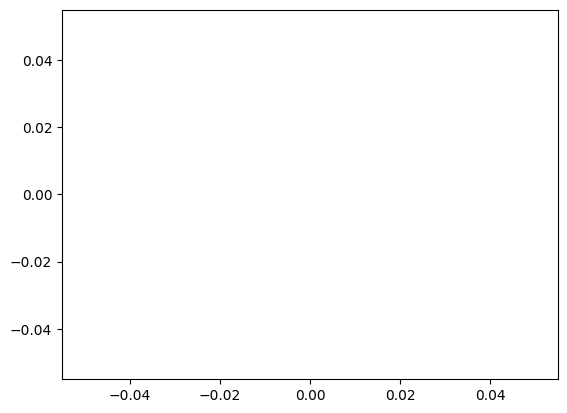

In [7]:
plt.plot(Ks,F_RMu(Ks))

In [81]:
TLO['r_info']['V'].iloc[0,0]#.plot()

-0.00250125062531265

In [38]:
K = 6

In [57]:
A = TLO['Theta_last'].loc[K].to_numpy(dtype=float)

In [58]:
((A[:N] + np.pi)%(np.pi*2) - np.pi)

array([-2.36056021,  1.31903964, -1.42770378, -2.15969516,  2.31665829,
        2.81034738, -2.59608085, -0.72685759,  0.79446064, -2.12902454,
       -2.93468508, -2.57513855, -2.32229645, -2.11447277, -1.93033677,
       -1.75987327, -1.59702009, -1.43731682, -1.27695956, -1.11225737,
       -0.93909108, -0.75202978, -0.54235185, -0.29130337, -0.8869053 ,
       -1.97931722, -1.06315308, -0.57790413, -0.1829438 , -2.94178335,
        0.01141546, -0.03661925,  0.18969314,  1.2896145 ,  1.58528855,
        1.72156023, -1.67872378,  2.14536732, -1.34693259,  0.05839328,
        0.22499125,  0.34501443,  0.45605356,  0.57452312,  0.68104056,
        0.76194873,  0.81770185,  0.85543983,  0.88258887,  0.90404722,
        0.92115905,  0.93087573,  0.92952516,  0.92515868,  0.97959822,
        1.16064097, -0.23434497,  2.25558442, -2.93742648, -2.92080984,
       -2.90527839, -2.89070892, -2.87698985, -2.86402149, -2.85171569,
       -2.83999514, -2.82879244, -2.81804912, -2.8077146 , -2.79

In [59]:
np.sin(((A[:N] + np.pi)%(np.pi*2) - np.pi))

array([-7.04013019e-01,  9.68476314e-01, -9.89779719e-01, -8.31552823e-01,
        7.34503246e-01,  3.25220863e-01, -5.18855681e-01, -6.64524700e-01,
        7.13485797e-01, -8.48194930e-01, -2.05434421e-01, -5.36643365e-01,
       -7.30665505e-01, -8.55812699e-01, -9.36058616e-01, -9.82178145e-01,
       -9.99656177e-01, -9.91104830e-01, -9.57139693e-01, -8.96700169e-01,
       -8.07021694e-01, -6.83122524e-01, -5.16151767e-01, -2.87200930e-01,
       -7.75120189e-01, -9.17709406e-01, -8.73892599e-01, -5.46269621e-01,
       -1.81925030e-01, -1.98482429e-01,  1.14152102e-02, -3.66110695e-02,
        1.88557549e-01,  9.60728163e-01,  9.99894990e-01,  9.88656634e-01,
       -9.94181484e-01,  8.39425534e-01, -9.75046985e-01,  5.83601004e-02,
        2.23097836e-01,  3.38210259e-01,  4.40408439e-01,  5.43434537e-01,
        6.29601798e-01,  6.90332643e-01,  7.29576053e-01,  7.54859467e-01,
        7.72385793e-01,  7.85836281e-01,  7.96303262e-01,  8.02143174e-01,
        8.01335973e-01,  

In [61]:
np.sin(A[:N])

array([-7.04013019e-01,  9.68476314e-01, -9.89779719e-01, -8.31552823e-01,
        7.34503246e-01,  3.25220863e-01, -5.18855681e-01, -6.64524700e-01,
        7.13485797e-01, -8.48194930e-01, -2.05434421e-01, -5.36643365e-01,
       -7.30665505e-01, -8.55812699e-01, -9.36058616e-01, -9.82178145e-01,
       -9.99656177e-01, -9.91104830e-01, -9.57139693e-01, -8.96700169e-01,
       -8.07021694e-01, -6.83122524e-01, -5.16151767e-01, -2.87200930e-01,
       -7.75120189e-01, -9.17709406e-01, -8.73892599e-01, -5.46269621e-01,
       -1.81925030e-01, -1.98482429e-01,  1.14152102e-02, -3.66110695e-02,
        1.88557549e-01,  9.60728163e-01,  9.99894990e-01,  9.88656634e-01,
       -9.94181484e-01,  8.39425534e-01, -9.75046985e-01,  5.83601004e-02,
        2.23097836e-01,  3.38210259e-01,  4.40408439e-01,  5.43434537e-01,
        6.29601798e-01,  6.90332643e-01,  7.29576053e-01,  7.54859467e-01,
        7.72385793e-01,  7.85836281e-01,  7.96303262e-01,  8.02143174e-01,
        8.01335973e-01,  

In [41]:
np.sin(A[:N])

array([-7.04013019e-01,  9.68476314e-01, -9.89779719e-01, -8.31552823e-01,
        7.34503246e-01,  3.25220863e-01, -5.18855681e-01, -6.64524700e-01,
        7.13485797e-01, -8.48194930e-01, -2.05434421e-01, -5.36643365e-01,
       -7.30665505e-01, -8.55812699e-01, -9.36058616e-01, -9.82178145e-01,
       -9.99656177e-01, -9.91104830e-01, -9.57139693e-01, -8.96700169e-01,
       -8.07021694e-01, -6.83122524e-01, -5.16151767e-01, -2.87200930e-01,
       -7.75120189e-01, -9.17709406e-01, -8.73892599e-01, -5.46269621e-01,
       -1.81925030e-01, -1.98482429e-01,  1.14152102e-02, -3.66110695e-02,
        1.88557549e-01,  9.60728163e-01,  9.99894990e-01,  9.88656634e-01,
       -9.94181484e-01,  8.39425534e-01, -9.75046985e-01,  5.83601004e-02,
        2.23097836e-01,  3.38210259e-01,  4.40408439e-01,  5.43434537e-01,
        6.29601798e-01,  6.90332643e-01,  7.29576053e-01,  7.54859467e-01,
        7.72385793e-01,  7.85836281e-01,  7.96303262e-01,  8.02143174e-01,
        8.01335973e-01,  

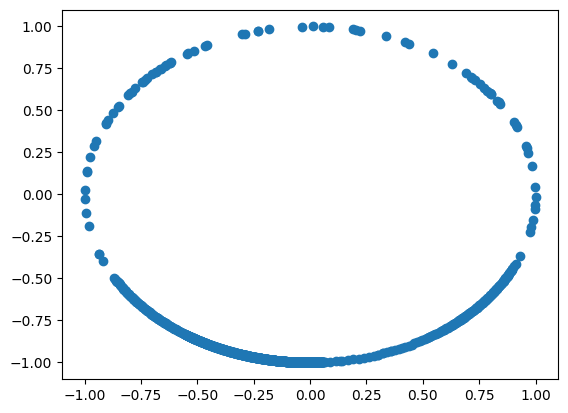

In [40]:
plt.scatter(np.sin(A[:N]),np.cos(A[:N]))

In [549]:
Qsimul.get_R_last(G[0,'I'],500)

(0.5512750127708986, 0.0029609149709159924)

In [128]:
r_infos[K,m] = Qsimul.get_r_clu_last()
df_groups[K,m] = Qsimul.df_group
avg_dthetas[K,m] = Qsimul.avg_dtheta

In [129]:
for i in tqdm(range(20)):
    K += 0.4
    K = np.round(K,3)
    # A = Qsimul.Theta_last
    # Qsimul.Theta_init = A
    Qsimul.K = K
    sol = Qsimul.solve_short()
    df_groups[K,m] = Qsimul.df_group
    r_infos[K,m] = Qsimul.get_r_clu_last()
    avg_dthetas[K,m] = Qsimul.avg_dtheta

  0%|          | 0/20 [00:00<?, ?it/s]

In [130]:
df_rs = [*r_infos.values()]
df = pd.concat(df_rs,axis=0)

df_g = [*df_groups.values()]
gs = []
for a in df_g:
    gs.append(a.to_numpy()[0])
# df_g = pd.concat(df_g,axis=0)

In [29]:
plt.imshow(abs(np.array(gs,dtype=float)))
plt.gca().set_aspect('auto')

NameError: name 'gs' is not defined

In [79]:
df_rs = [*r_infos.values()]
df = pd.concat(df_rs,axis=0)
df['dV','|1+-0|'] = np.abs(df['V']['1+'] -  df['V']['0'])
df['dV','|2+-1+|'] = np.abs(df['V']['2+'] -  df['V']['1+'])
df['dV','|3+-2+|'] = np.abs(df['V']['3+'] -  df['V']['2+'])
df['dV','|1--0|'] = np.abs(df['V']['1-'] -  df['V']['0'])
df['dV','|2--1-|'] = np.abs(df['V']['2-'] -  df['V']['1-'])
df['dV','|3--2-|'] = np.abs(df['V']['3-'] -  df['V']['2-'])

df['dV/dV','|1+-2+|/|3+-2+|'] = df['dV','|2+-1+|']/ df['dV','|3+-2+|']
df['dV/dV','|1+-0|/|2+-1+|'] = df['dV','|1+-0|']/ df['dV','|2+-1+|']

df['dV/dV','|1--0|/|2--1-|'] = df['dV','|1--0|']/ df['dV','|2--1-|']


<Axes: xlabel='K,m'>

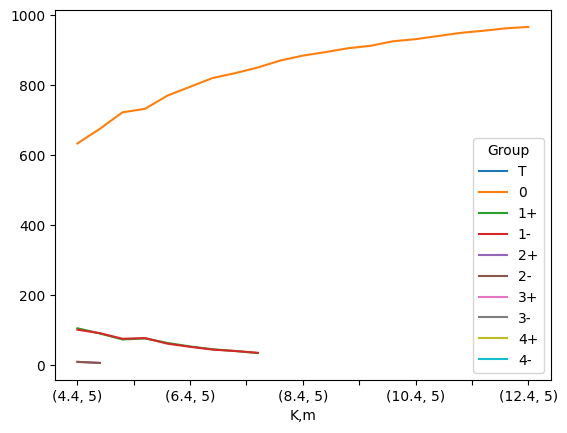

In [80]:
df['S'].plot()

In [529]:
G,GM,GP = Qsimul.get_Group()

In [12]:
index = pd.MultiIndex.from_product([[K],[m]],names=['K','m'])
column = pd.MultiIndex.from_product([['R_mean','R_std','V','S'],['T','0','1+','1-','2+','2-','3+','3-','4+','4-']],names=['Categori','Group'])
df_r = pd.DataFrame(columns=column,index=index)
df_group = pd.DataFrame(columns=range(N),index=index)
clu_name = ['T','0','1+','1-','2+','2-','3+','3-','4+','4-']
for clu in clu_name:
    df_r['R_mean',clu][K,m] = r[clu,'RM']
    df_r['R_std',clu][K,m] = r[clu,'RSTD']
    df_r['V',clu][K,m] = r[clu,'V']
    if clu != 'T':
        df_r['S',clu][K,m] = r[clu,'S']

In [83]:
df = TLO['r_info']

In [84]:
df['dV','|1+-0|'] = np.abs(df['V']['1+'] -  df['V']['0'])
df['dV','|2+-1+|'] = np.abs(df['V']['2+'] -  df['V']['1+'])
df['dV','|3+-2+|'] = np.abs(df['V']['3+'] -  df['V']['2+'])
df['dV','|1--0|'] = np.abs(df['V']['1-'] -  df['V']['0'])
df['dV','|2--1-|'] = np.abs(df['V']['2-'] -  df['V']['1-'])
df['dV','|3--2-|'] = np.abs(df['V']['3-'] -  df['V']['2-'])

df['dV/dV','|1+-2+|/|3+-2+|'] = df['dV','|2+-1+|']/ df['dV','|3+-2+|']
df['dV/dV','|1+-0|/|2+-1+|'] = df['dV','|1+-0|']/ df['dV','|2+-1+|']

df['dV/dV','|1--0|/|2--1-|'] = df['dV','|1--0|']/ df['dV','|2--1-|']

<Axes: xlabel='K,m'>

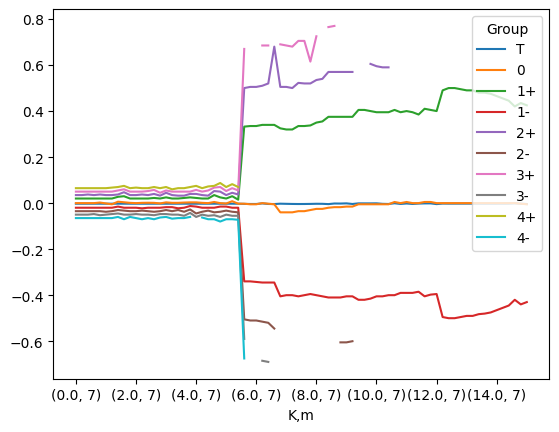

In [86]:
df['V'].plot()

<Axes: xlabel='K,m'>

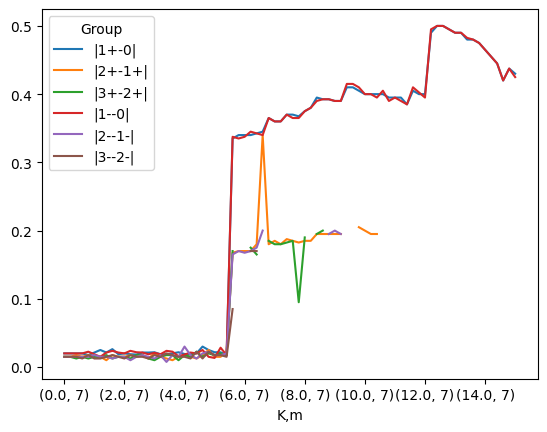

In [85]:
df['dV'].plot()

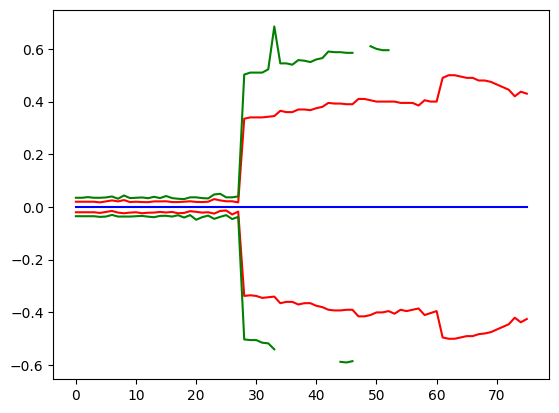

In [92]:
plt.plot([*avg_dthetas.values()])
plt.plot(df['V']['1+'].values-df['V']['0'].values,color='red',zorder=3)
plt.plot(df['V']['0'].values-df['V']['0'].values,color='blue',zorder=3)
plt.plot(df['V']['1-'].values-df['V']['0'].values,color='red',zorder=3)
plt.plot(df['V']['2-'].values-df['V']['0'].values,color='green',zorder=3)
plt.plot(df['V']['2+'].values-df['V']['0'].values,color='green',zorder=3)


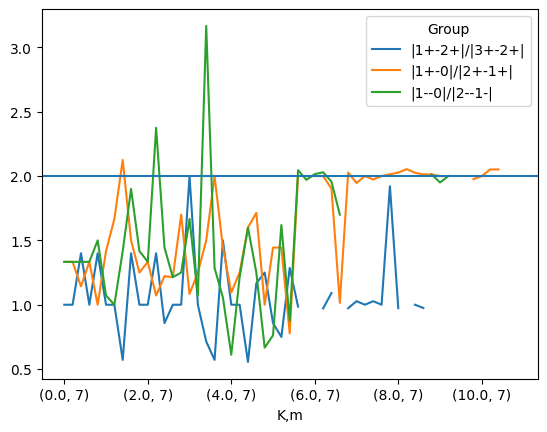

In [87]:
df['dV/dV'].plot()
plt.axhline(2)

<Axes: xlabel='K,m'>

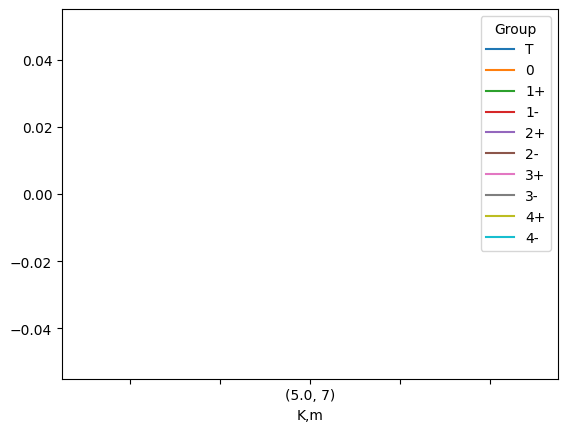

In [534]:
df['R_mean'].plot()

In [63]:
clu_name = set()
RMs = [] 
RSs = [] 
for clu,_ in r_info_last.keys():
    clu_name.add(clu)



In [67]:
df['V']

,Group,T,0,1+,1-,2+,2-,3+,3-,4+,4-
K,m,,,,,,,,,,
6,7,-0.002006,0.0,0.365183,-0.370185,0.550275,-0.735368,0.735368,NaN,NaN,NaN


In [40]:
df['R_mean']['T']

K  m
6  7    NaN
Name: T, dtype: object

In [32]:
pd.Series(r_info_last)

T   RM      0.631421
    RSTD    0.071420
0   RM      0.676141
    RSTD    0.001655
1+  RM      0.091049
    RSTD    0.002248
1-  RM      0.092947
    RSTD    0.002375
2+  RM      0.006453
    RSTD    0.000231
2-  RM      0.004712
    RSTD    0.000254
3+  RM      0.004489
    RSTD    0.000206
3-  RM           NaN
    RSTD         NaN
4+  RM           NaN
    RSTD         NaN
4-  RM           NaN
    RSTD         NaN
dtype: float64

## 할려는 것
데이터 모아서 데이터 프레임 형태로 만들기

In [24]:
clu_name

{'0', '1+', '1-', '2+', '2-', '3+', '3-', '4+', '4-', 'T'}

In [25]:
pd.DataFrame(np.array(r_info_last))

ValueError: Must pass 2-d input. shape=()

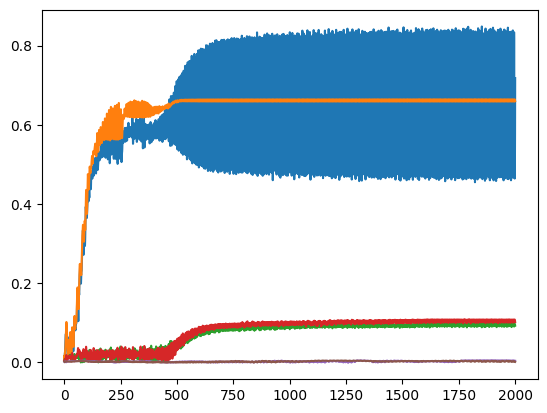

In [99]:

tm = Qsimul.t
plt.plot(tm,r_info['T','R'])
plt.plot(tm,r_info[0,'R'])
plt.plot(tm,r_info['1+','R'])
plt.plot(tm,r_info['1-','R'])
plt.plot(tm,r_info['2+','R'])
plt.plot(tm,r_info['2-','R'])

In [100]:
for i in range(0):
    print(i)

In [108]:
pd.DataFrame(r_info_last)

ValueError: If using all scalar values, you must pass an index

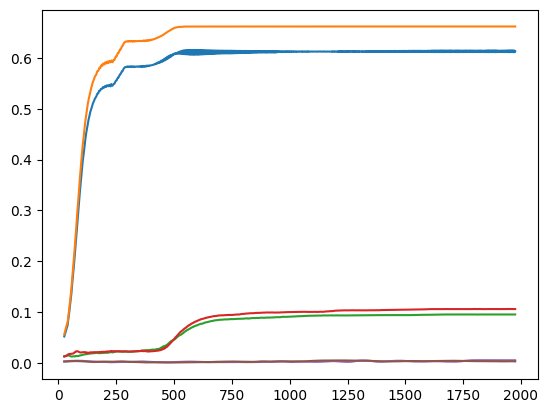

In [102]:
tm = r_info['tm']
# tm = Qsimul.t
plt.plot(tm,r_info['T','RM'])
plt.plot(tm,r_info[0,'RM'])
plt.plot(tm,r_info['1+','RM'])
plt.plot(tm,r_info['1-','RM'])

plt.plot(tm,r_info['2+','RM'])
plt.plot(tm,r_info['2-','RM'])

In [103]:
GP[3,'I']

array([1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932,
       1933, 1934])

In [104]:
AVD = Qsimul.avg_dtheta
G,GM,GP = Qsimul.get_Group(Nc=10)

0.0
72.0
97.0
109.0
145.0


In [105]:
GP[3,'I']


array([1916, 1917, 1918, 1919, 1920, 1921, 1922, 1923, 1924, 1925, 1926,
       1927, 1928, 1929, 1930])

In [106]:
len(AVD)

2000

0.0
72.0
97.0
109.0
145.0


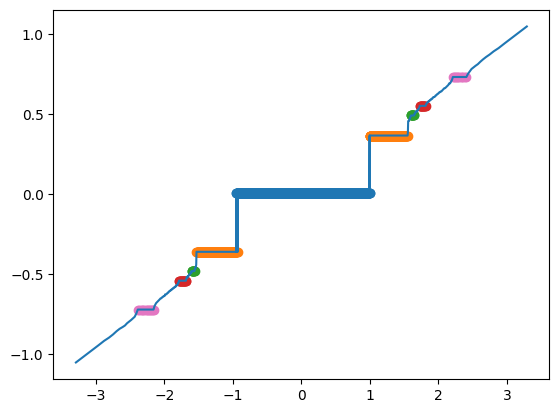

In [107]:
AVD = Qsimul.avg_dtheta
G,GM,GP = Qsimul.get_Group(Nc=5)
omega = Qsimul.omega
plt.plot(omega,AVD)
plt.scatter(omega[G[0,'I']],AVD[G[0,'I']])
plt.scatter(omega[GM[1,'I']],AVD[GM[1,'I']],color='tab:orange')
plt.scatter(omega[GP[1,'I']],AVD[GP[1,'I']],color='tab:orange')
plt.scatter(omega[GM[2,'I']],AVD[GM[2,'I']],color= 'tab:green')
plt.scatter(omega[GP[2,'I']],AVD[GP[2,'I']],color= 'tab:green')
plt.scatter(omega[GM[3,'I']],AVD[GM[3,'I']],color= 'tab:red')
plt.scatter(omega[GP[3,'I']],AVD[GP[3,'I']],color= 'tab:red')


plt.scatter(omega[GM[4,'I']],AVD[GM[4,'I']],color='tab:pink')
plt.scatter(omega[GP[4,'I']],AVD[GP[4,'I']],color='tab:pink')

In [94]:
print(G[0,'V'] - GM[1,'V'],GP[1,'V'] - G[0,'V'])
print(GM[1,'V'] - GM[2,'V'],GP[2,'V'] - GP[1,'V'])

0.3701850925462731 0.3651825912956478
0.12506253126563283 0.12506253126563283


In [69]:
G,GM,GP = Qsimul.get_Group(2000)
GM

0.0
60.0
90.0
120.0


{(1,
  'I'): array([ 90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
        103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
        116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
        129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
        142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
        155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
        168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180,
        181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193,
        194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206,
        207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,
        220, 221, 222, 224, 225, 227, 230, 231, 233, 235, 238, 239]),
 (1, 'R'): array([-58.]),
 (1, 'L'): 142,
 (1, 'V'): -0.2901450725362681,
 (2,
  'I'): array([70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86,
        87, 88, 89]),
 (2,

In [600]:
temp = 1/N*np.sum(np.exp(1j*theta[:, []]), axis=1)
np.mean(np.nan)

nan

# chceck Theory

In [157]:
import numpy as np
import pandas as pd
from TO_sim.gen_Distribution import Normal, Quantile_Normal as Q_Normal, Lorentzian
from scipy.integrate import quad
from scipy.stats import norm
from numba import jit
from scipy import interpolate



def g_n(x):
    return norm.pdf(x,0,1)

def FX_lock1(X,m,g=g_n):
    # integrand_lock = lambda x:np.cos(x)**2*g(X*np.sin(x))
    integrand_lock = lambda x:g(x)*np.sqrt(1-(x/X)**2)
    
    a = 1/np.sqrt(X*m)
    b = 4/np.pi * a - 0.3056*a**3
    b = np.where(np.where(a>1.193,1,b)>=1,1,b)

    omega_p = b*X
    
    A = omega_p/X
    I_l,err = quad(integrand_lock, -omega_p,omega_p,limit=200)
    return I_l/X

def FX_drift1(X,m,g=g_n):
    if m == 0:
        return 0
    a = 1/np.sqrt(X*m)
    b = 4/np.pi * a - 0.3056*a**3
    b = np.where(np.where(a>1.193,1,b)>=1,1,b)


    O_p = b*X
    # O_p = (4/np.pi)*np.sqrt(X/m)

    # integrand_drift = lambda x:1/(m*x**2+1/m)*g(x)
    integrand_drift = lambda x:1/(m*x**2+1/m)*g(x)
    I_d,err = quad(integrand_drift,O_p,np.inf,limit=200)
    return -1*I_d

def FX_0(X,m,O_0,g=g_n):
        O_d = min(O_0,X)
        theta_0 = np.arcsin(O_d/X)
        integrand_l = lambda x:np.cos(x)**2*g(X*np.sin(x))
        integrand_d = lambda x:(1/x**2)*g(x)
        I_l,err_l = quad(integrand_l,-theta_0,theta_0,limit=200) #lock
        I_d,err_d = quad(integrand_d,O_d,np.inf,limit=200) #drift
        Fl = 1*I_l
        Fd = - 1/(m)*I_d
        F0 = Fl + Fd
        return F0,Fl,Fd
get_FX_l1 = np.vectorize(FX_lock1)
get_FX_d1 = np.vectorize(FX_drift1)
get_FX_0 = np.vectorize(FX_0)

def Make_R0_function(m,O_0,K_max=15,g_n=g_n):
    X = np.linspace((0.01),(20),num=3000)
    F0,Fl,Fd = get_FX_0(X,m,O_0,g=g_n)
    RX_l1 = X*Fl
    RX_d1 = X*Fd
    RX_F = RX_l1 + RX_d1
    R = RX_l1 + RX_d1
    IK = np.nanmax((R/X))
    Kb =1/IK
    rb = X[np.nanargmax((R/X))]*IK

    Ks = np.linspace(0.5,K_max+0.1,50000)
    A = np.where(np.abs(RX_F*Ks.reshape(-1,1)-X)<5e-5)
    RR = RX_F*np.ones_like(Ks.reshape(-1,1))
    KK = np.ones_like(RX_F)*Ks.reshape(-1,1)

    RR_0 = RX_l1*np.ones_like(Ks.reshape(-1,1))
    U,= np.where(RR[A] >= rb)
    D,= np.where(RR[A] < rb)
    Ku = KK[A][U]
    Kd = KK[A][D]
    Ku,Ku_idx,c=np.unique(Ku,return_counts=True,return_index=True)
    Kd,Kd_idx,c=np.unique(Kd,return_counts=True,return_index=True)

    F_RMu = interpolate.interp1d(KK[A][U][Ku_idx], RR[A][U][Ku_idx], kind='quadratic',bounds_error=False)
    F_R0u = interpolate.interp1d(KK[A][U][Ku_idx], RR_0[A][U][Ku_idx], kind='quadratic',bounds_error=False)
    if m == 0:
        F_RMd = F_RMu
        F_R0d = F_R0u
    else:
        F_RMd = interpolate.interp1d(KK[A][D][Kd_idx], RR[A][D][Kd_idx], kind='quadratic',bounds_error=False)
        F_R0d = interpolate.interp1d(KK[A][D][Kd_idx], RR_0[A][D][Kd_idx], kind='quadratic',bounds_error=False)


    return F_RMd,F_RMu,F_R0d,F_R0u

def g_sec(x,Or,Om):
    g = norm.pdf(x,-Or,1)
    dO = abs(Or-Om)
    return np.where(x<-dO,1e-6,g)

def get_O_r(r):
    r_s = np.linspace(r/2+0.5,1,5000,endpoint=False)
    A = norm.ppf(r_s)
    return np.mean(A)

def F_lock2(r,K,m,F_R0,F_RM,O_pm=None, g=g_sec):
    X = K*r
    a = 1/np.sqrt(X*m)
    b = 4/np.pi * a - 0.3056*a**3
    bs = np.where(np.where(a>1.193,1,b)>=1,1,b)

    r_0 = F_R0(K)
    if O_pm is None:
        O_pm = 4/np.pi*np.sqrt(K*F_RM(K)/m) - 0.3056/np.sqrt(K*F_RM(K)*m**3)
    # shift_O = -(K**2*r*r_0)/(2*m*(1/m**2+(O_pm)**2)) -(K**2*r*r)/(2*m*(1/m**2+(2*O_pm)**2))
    shift_O = -(K**2*r*r_0)/(2*m*(1/m**2+(O_pm)**2)) + (K**2*r*r)/(2*m**2*O_pm*(1/m**2+(2*O_pm)**2))
    integrand_lock = lambda x:g(x,O_pm-shift_O,O_pm)*np.sqrt(1-((x)/X)**2)
    omega_p = bs*X
    O_min = -shift_O - omega_p
    if O_min<0:
        m_ = O_min
    else:
        m_ = np.nan
        
    I_l,err = quad(integrand_lock, shift_O,+omega_p,limit=200)
    return I_l/X,m_
def F_drift2(r,K,m,F_R0,F_RM,O_pm=None,g=g_sec):
    X = K*r
    a = 1/np.sqrt(X*m)
    b = 4/np.pi * a - 0.3056*a**3
    bs = np.where(np.where(a>1.193,1,b)>=1,1,b)


    r_0 = F_R0(K)
    if O_pm is None:
        O_pm = 4/np.pi*np.sqrt(K*F_RM(K)/m) - 0.3056/np.sqrt(K*F_RM(K)*m**3)
    O_p = bs*X
    # shift_O = -(K**2*r*r_0)/(2*m*(1/m**2+(O_pm)**2)) -(K**2*r*r)/(2*m*(1/m**2+(2*O_pm)**2))
    shift_O = -(K**2*r*r_0)/(2*m*(1/m**2+(O_pm)**2)) + (K**2*r*r)/(2*m**2*O_pm*(1/m**2+(2*O_pm)**2))
    integrand_drift = lambda x:1/(2*(m*(x+O_pm-shift_O)**2+1/m))*g(x,O_pm-shift_O,O_pm)
    # integrand_drift = lambda x:1/(2*(m*(x)**2+1/m))*g(x,O_pm-shift_O,O_pm)
    # integrand_drift = lambda x:1/(2*(m*(x)**2+1/m))*g(x,O_pm-shift_O,O_pm)
    # integrand_drift = lambda x:1/(2*x**2)*g(x+shift_O,O_r,O_pm)
    I_d,err = quad(integrand_drift,+O_p,np.inf,limit=200)
    # I_dm,err = quad(integrand_drift,-np.inf,-O_p,limit=200)
    return -1*(I_d)#+I_dm)

def F_sec(r,K,m,F_R0,F_RM,O_pm=None,g=g_sec):
    F_l2,m_ = F_lock2(r,K,m,F_R0,F_RM,O_pm,g)
    F_d2 = F_drift2(r,K,m,F_R0,F_RM,O_pm,g)
    return F_l2,F_d2,F_l2+F_d2,m_

get_Fp_l = np.vectorize(F_lock2)
get_Fp_d = np.vectorize(F_drift2)
get_F2 = np.vectorize(F_sec)
# get_F20 = np.vectorize(F_sec0)


def Make_R_function(m,K_max=15,g_n=g_n):
    X = np.linspace((0.01),(20),num=3000)
    RX_l1 = X*get_FX_l1(X,m,g=g_n)
    RX_d1 = X*get_FX_d1(X,m,g=g_n)
    RX_F = RX_l1 + RX_d1
    R = RX_l1 + RX_d1
    IK = np.nanmax((R/X))
    Kb =1/IK
    rb = X[np.nanargmax((R/X))]*IK

    Ks = np.linspace(0.5,K_max+0.1,50000)
    A = np.where(np.abs(RX_F*Ks.reshape(-1,1)-X)<5e-5)
    RR = RX_F*np.ones_like(Ks.reshape(-1,1))
    KK = np.ones_like(RX_F)*Ks.reshape(-1,1)

    RR_0 = RX_l1*np.ones_like(Ks.reshape(-1,1))
    U,= np.where(RR[A] >= rb)
    D,= np.where(RR[A] < rb)
    Ku = KK[A][U]
    Kd = KK[A][D]
    Ku,Ku_idx,c=np.unique(Ku,return_counts=True,return_index=True)
    Kd,Kd_idx,c=np.unique(Kd,return_counts=True,return_index=True)

    F_RMu = interpolate.interp1d(KK[A][U][Ku_idx], RR[A][U][Ku_idx], kind='quadratic',bounds_error=False)
    F_R0u = interpolate.interp1d(KK[A][U][Ku_idx], RR_0[A][U][Ku_idx], kind='quadratic',bounds_error=False)
    if m == 0:
        F_RMd = F_RMu
        F_R0d = F_R0u
    else:
        F_RMd = interpolate.interp1d(KK[A][D][Kd_idx], RR[A][D][Kd_idx], kind='quadratic',bounds_error=False)
        F_R0d = interpolate.interp1d(KK[A][D][Kd_idx], RR_0[A][D][Kd_idx], kind='quadratic',bounds_error=False)

    return F_RMd,F_RMu,F_R0d,F_R0u

def get_r_sec(K,m,FR0,FRM,O_pm=None,samples=200,g_sec=g_sec):
    r0_ =  FR0(K)
    r_sd,r_su = np.nan,np.nan
    r_su_d,r_su_l = np.nan,np.nan
    mu = np.nan
    md = np.nan
    if (K == 0)or (m==0):
        return r_sd,r_su,r_su_d,r_su_l,md,mu
    r_test = np.linspace(1e-5,(1-r0_)/2,samples)
    F_l2,F_d2,F2,m_ = get_F2(r_test,K,m,FR0,FRM,O_pm)
    R2_interpolate  = interpolate.interp1d(r_test,F2, kind='linear',bounds_error=False)
    F2l_interpolate  = interpolate.interp1d(r_test,F_l2, kind='linear',bounds_error=False)
    m_interpolate  = interpolate.interp1d(r_test,m_, kind='linear',bounds_error=False)
    r_test2 = np.linspace(1e-5,(1-r0_)/2,5000)
    Fs = R2_interpolate(r_test2)
    cross_point = np.sign((Fs[0:-1]-1/K)*(Fs[1:]-1/K))*(-0.5) + 0.5
    arg_check, = np.where(cross_point)

    r_sec = (r_test2[arg_check] +r_test2[arg_check+1])/2
    if len(r_sec)==2:
        r_sd,r_su = r_sec
    if len(r_sec)==1:
        r_su = r_sec
    f_su = F2l_interpolate(r_su)
    f_sd = F2l_interpolate(r_sd)
    mu = m_interpolate(r_su)
    md = m_interpolate(r_sd)
    r_su_l = r_su*K*f_su
    r_sd_l = r_sd*K*f_sd
    return r_sd,r_su,r_sd_l,r_su_l,md,mu

# def get_r_sec0(K,r_last,shift_O,m,O_0,O_20,FR,samples=200):
#     r0_ =  FR(K)
#     r_sd,r_su = np.nan,np.nan
#     r_sd_l,r_su_l = np.nan,np.nan
#     mu = np.nan
#     md = np.nan
#     if (K == 0)or (m==0):
#         return r_sd,r_su,r_sd_l,r_su_l
#     r_test = np.linspace(1e-5,(1-r0_)/2,samples)
#     F2,Fl,Fd = get_F20(r_test,r_last,K,shift_O,m,O_0,O_20,FR)
#     R2_interpolate  = interpolate.interp1d(r_test,F2, kind='linear',bounds_error=False)
#     Rl_interpolate  = interpolate.interp1d(r_test,Fl, kind='linear',bounds_error=False)
#     r_test2 = np.linspace(1e-5,(1-r0_)/2,5000)
#     Fs = R2_interpolate(r_test2)
#     Fls = Rl_interpolate(r_test2)
#     cross_point = np.sign((Fs[0:-1]-1/K)*(Fs[1:]-1/K))*(-0.5) + 0.5
#     arg_check, = np.where(cross_point)

#     r_sec = (r_test2[arg_check] +r_test2[arg_check+1])/2
#     F_ls = (Fls[arg_check] +Fls[arg_check+1])/2
#     if len(r_sec)>=3:
#         r_su = r_sec[-1]
#         r_su_l = F_ls[-1]*K*r_su
#     if len(r_sec)==2:
#         r_sd,r_su = r_sec
#         r_sd_l,r_su_l = F_ls[0]*K*r_sd,F_ls[1]*K*r_su

#     if len(r_sec)==1:
#         r_su = r_sec
#         r_su_l = F_ls*K*r_su
#     return r_sd,r_su,r_sd_l,r_su_l

get_r_sec_np = np.vectorize(get_r_sec)
# get_r_sec0_np = np.vectorize(get_r_sec0)


### GET O_R
def get_shift(O_0):
    r_last = norm.cdf(O_0)
    O_samples = np.linspace(O_0,4,1000)
    r_ = norm.cdf(O_samples)
    def get_O_r(r):
        r_s = np.linspace(r_last,r,10000,endpoint=False)
        A = norm.ppf(r_s)
        O_r = np.mean(A)
        shift_O = O_r - O_0
        return O_r,shift_O
    FO_r = np.vectorize(get_O_r)
    O_rs,shift_Os = FO_r(r_)
    Ops = O_samples-O_rs
    F_shift  = interpolate.interp1d(Ops,shift_Os, kind='linear',bounds_error=False)
    F_OR  = interpolate.interp1d(O_samples,O_rs, kind='linear',bounds_error=False)

    return F_shift,F_OR

def F_sec0(r,K,m,O_0,O_20,F_R0,F_S,F_OR,g=g_sec):
    X = K*r
    a = 1/np.sqrt(X*m)
    b = 4/np.pi * a - 0.3056*a**3
    r_0 = F_R0(K)
    bs = np.where(np.where(a>1.193,1,b)>=1,1,b)
    a0 = 1/np.sqrt(K*r_0*m)

    O_pm = O_0
    shift_O = (K**2*r*r_0)/(2*m*(1/m**2+(O_pm)**2)) - (K**2*r*r)/(2*m**2*O_pm*(1/m**2+(2*O_pm)**2))#K**2 * r_0 * r/(2*m*(1/m**2+(O_0)**2)) + K**2 * r * r/(2*m*(1/m**2+(2*O_0)**2))

    shift_temp = F_S(X-shift_O)
    MAX = O_0+shift_temp+X
    # if MAX<O_20:
        # shift_temp = F_S(X)
        # O_20 = MAX
    OM = -shift_temp
    OP = min(O_20-O_0-shift_temp,X)
    
    if X<shift_temp:
        OM = 0
        OP = 0
    
    integrand_drift = lambda x:1/(2*(m*(x+shift_O)**2+1/m))*g(x,O_pm+shift_O,O_pm)
    integrand_lock = lambda x:g(x,O_pm+shift_temp,O_pm)*np.sqrt(1-((x)/X)**2)

    I_d,err = quad(integrand_drift,OP,np.inf,limit=200)
    I_l,err = quad(integrand_lock,OM ,OP,limit=200)
    
    return I_l/X-I_d,I_l/X,-I_d,shift_temp
get_F20 = np.vectorize(F_sec0)

def get_r_sec0(K,m,O_0,O_20,FR,F_S,F_OR,samples=200):
    r0_ =  FR(K)
    r_sd,r_su = np.nan,np.nan
    r_sd_l,r_su_l = np.nan,np.nan
    mu = np.nan
    md = np.nan
    shift_Os = np.nan
    if (K == 0)or (m==0):
        return r_sd,r_su,r_sd_l,r_su_l
    r_test = np.linspace(1e-5,(1-r0_)/2,samples)
    F2,Fl,Fd,shift_Os = get_F20(r_test,K,m,O_0,O_20,FR,F_S,F_OR)
    R2_interpolate  = interpolate.interp1d(r_test,F2, kind='linear',bounds_error=False)
    Rl_interpolate  = interpolate.interp1d(r_test,Fl, kind='linear',bounds_error=False)
    r_test2 = np.linspace(1e-5,(1-r0_)/2,5000)
    Fs = R2_interpolate(r_test2)
    Fls = Rl_interpolate(r_test2)
    cross_point = np.sign((Fs[0:-1]-1/K)*(Fs[1:]-1/K))*(-0.5) + 0.5
    arg_check, = np.where(cross_point)

    r_sec = (r_test2[arg_check] +r_test2[arg_check+1])/2
    F_ls = (Fls[arg_check] +Fls[arg_check+1])/2
    if len(r_sec)==2:
        r_sd,r_su = r_sec
        r_sd_l,r_su_l = F_ls[0]*K*r_sd,F_ls[1]*K*r_su

    if len(r_sec)==1:
        r_su = r_sec
        r_su_l = F_ls*K*r_su


    return r_sd,r_su,r_sd_l,r_su_l
get_r_sec0_np = np.vectorize(get_r_sec0)

def get_shift_O(r0,rp,O_O,K,m):
    shift = (K**2*r0*rp)/(2*m*(1/m**2+(O_O)**2)) - (K**2*rp*rp)/(2*m**2*O_O*(1/m**2+(2*O_O)**2))
    return shift


def get_OPM(RM,K,m):
    OPM =  4/np.pi*np.sqrt(K*RM/m) - 0.3056/np.sqrt(K*RM*m**3)
    return OPM

get_FX_0 = np.vectorize(FX_0)

In [ ]:
Ks = np.linspace(5,15,15)
%timeit r_sd,r_su,r_sd_l,r_su_l,md,mu = get_r_sec_np(Ks,m,O_R0u,O_RMu)

In [40]:
X = np.linspace((0.01),(20),num=300)
%timeit get_FX_0(X,5,0)

2.58 s ± 19.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [140]:
def g_n(x,O_0=0.0):
    return norm.pdf(x,O_0,1)
O_RMd,O_RMu,O_R0d,O_R0u =  Make_R_function(6)

In [158]:
Ks = np.linspace(5,15,15)
%timeit r_sd,r_su,r_sd_l,r_su_l,md,mu = get_r_sec_np(Ks,m,O_R0u,O_RMu)

11.2 s ± 75.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [149]:
!python3.11 -m pip install numba-scipy

    qiskit-terra (>=0.22.*)
                  ~~~~~~~^


In [8]:
m = 6

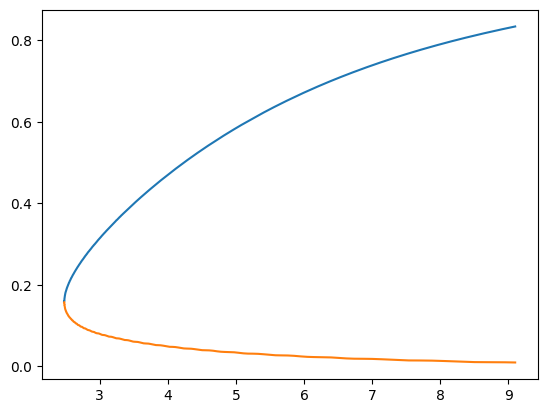

In [30]:
plt.plot(Ks,F_R0u(Ks))
plt.plot(Ks,F_R0d(Ks))

In [1]:
@jit(nopython=True)
def FX_lock1(X,m,g=g_n):
    # integrand_lock = lambda x:np.cos(x)**2*g(X*np.sin(x))
    def i_lock(x,X):
        return norm.pdf(x,0,1)*np.sqrt(1-(x/X)**2)
    # integrand_lock = lambda x:g(x)*np.sqrt(1-(x/X)**2)
    
    a = 1/np.sqrt(X*m)
    b = 4/np.pi * a - 0.3056*a**3
    b = np.where(np.where(a>1.193,1,b)>=1,1,b)

    omega_p = b*X
    
    A = omega_p/X
    I_l,err = quad(i_lock, -omega_p,omega_p,args=(X),limit=200)
    return I_l/X


NameError: name 'jit' is not defined

In [159]:
import numpy as np
import scipy.integrate as si
from numba import cfunc, carray, jit
import numba
from numba.types import intc, CPointer, float64
from scipy import LowLevelCallable
from scipy.stats import norm
from numba import njit, prange


from numba import njit
import numpy as np

@njit
def g(x, mean, std):
    return (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-0.5 * ((x - mean) / std) ** 2)
@njit
def g_sec(x,Or,Om):
    std = 1
    mean = -Or
    g = (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-0.5 * ((x - mean) / std) ** 2)
    dO = abs(Or-Om)
    return np.where(x<-dO,1e-6,g)

def jit_integrand_function(integrand_function):
    jitted_function = numba.jit(integrand_function, nopython=True)
    @cfunc(float64(intc, CPointer(float64)))
    def wrapped(n, xx):
        values = carray(xx, n)
        return jitted_function(values[0], values[1])
    return LowLevelCallable(wrapped.ctypes)

def jit_integrand_function2(integrand_function):
    jitted_function = numba.jit(integrand_function, nopython=True)
    
    @cfunc(float64(intc, CPointer(float64)))
    def wrapped(n, xx):
        if n < 5:
            raise ValueError("Not enough parameters passed to function.")
        values = carray(xx, n)  # 전달된 모든 파라미터를 포함하는 배열
        return jitted_function(values[0], values[1], values[2], values[3],values[4])
    
    return LowLevelCallable(wrapped.ctypes)



@jit_integrand_function
def integrand_l(x, X):
    return np.cos(x)**2*g(X*np.sin(x),0,1)
@jit_integrand_function
def integrand_d(x,X):
    return (1/x**2)*g(x,0,1)

@jit_integrand_function2
def integrand_Rl(x, X,O_O,O_p,m):
    return g(x,O_O,O_p)*np.sqrt(1-(x/X)**2)

@jit_integrand_function2
def integrand_Rd(x, X,O_O,O_p,m):
    if m == 0:
        return 0
    else:
        return X/(2*(m*x**2+1/m))*g(x,O_O,O_p)
    

@jit_integrand_function2
def integrand_Rl2(x, X,O_pm,shift_O,m):
    return g_sec(x,O_pm-shift_O,O_pm)*np.sqrt(1-(x/X)**2)

@jit_integrand_function2
def integrand_Rd2(x, X,O_pm,shift_O,m):
    return 1/(2*(m*(x+O_pm-shift_O)**2+1/m))*g_sec(x,O_pm-shift_O,O_pm)


def FX_0(X,m,O_0):
    O_d = min(O_0,X)
    theta_0 = np.arcsin(O_d/X)
    I_l,err_l = quad(integrand_l,-theta_0,theta_0,limit=200) #lock
    I_d,err_d = quad(integrand_d,O_d,np.inf,limit=200) #drift
    Fl = 1*I_l
    Fd = - 1/(m)*I_d
    F0 = Fl + Fd
    return F0,Fl,Fd
get_FX_0 = np.vectorize(FX_0)

def FX_Rld(X,m,O_0):
    a = 1/np.sqrt(X*m)
    b = 4/np.pi * a - 0.3056*a**3
    b = np.where(np.where(a>1.193,1,b)>=1,1,b)

    omega_p = b*X
    
    R_l,err = quad(integrand_Rl, -omega_p,omega_p,args=(X,O_0,1,m),limit=200)
    R_dr,err = quad(integrand_Rd,omega_p,np.inf,args=(X,O_0,1,m),limit=200)
    R_dl,err = quad(integrand_Rd,-np.inf,-omega_p,args=(X,O_0,1,m),limit=200)

    R_d = R_dr +  R_dl
    R = R_l - R_d
    return R_l,-R_d,R

get_FX_Rld = np.vectorize(FX_Rld)

def Make_R_function(m,O_0,K_max=15):
    X = np.linspace((0.01),(20),num=3000)
    RX_l1,RX_d1,RX_F = get_FX_Rld(X,m,O_0)
    R = RX_l1 + RX_d1
    IK = np.nanmax((R/X))
    Kb =1/IK
    rb = X[np.nanargmax((R/X))]*IK

    Ks = np.linspace(0.5,K_max+0.1,50000)
    A = np.where(np.abs(RX_F*Ks.reshape(-1,1)-X)<5e-5)
    RR = RX_F*np.ones_like(Ks.reshape(-1,1))
    KK = np.ones_like(RX_F)*Ks.reshape(-1,1)

    RR_0 = RX_l1*np.ones_like(Ks.reshape(-1,1))
    U,= np.where(RR[A] >= rb)
    D,= np.where(RR[A] < rb)
    Ku = KK[A][U]
    Kd = KK[A][D]
    Ku,Ku_idx,c=np.unique(Ku,return_counts=True,return_index=True)
    Kd,Kd_idx,c=np.unique(Kd,return_counts=True,return_index=True)

    F_RMu = interpolate.interp1d(KK[A][U][Ku_idx], RR[A][U][Ku_idx], kind='quadratic',bounds_error=False)
    F_R0u = interpolate.interp1d(KK[A][U][Ku_idx], RR_0[A][U][Ku_idx], kind='quadratic',bounds_error=False)
    if m == 0:
        F_RMd = F_RMu
        F_R0d = F_R0u
    else:
        F_RMd = interpolate.interp1d(KK[A][D][Kd_idx], RR[A][D][Kd_idx], kind='quadratic',bounds_error=False)
        F_R0d = interpolate.interp1d(KK[A][D][Kd_idx], RR_0[A][D][Kd_idx], kind='quadratic',bounds_error=False)

    return F_RMd,F_RMu,F_R0d,F_R0u



def F_sec(r,K,m,F_R0,F_RM,O_pm=None, g=g_sec):
    X = K*r
    a = 1/np.sqrt(X*m)
    b = 4/np.pi * a - 0.3056*a**3
    bs = np.where(np.where(a>1.193,1,b)>=1,1,b)

    r_0 = F_R0(K)
    if O_pm is None:
        O_pm = 4/np.pi*np.sqrt(K*F_RM(K)/m) - 0.3056/np.sqrt(K*F_RM(K)*m**3)
        #F_RM으로 부터 얻는 곡선, 만약 shift가 있는경우 그 값에서 부터 시작됨
    # shift_O = -(K**2*r*r_0)/(2*m*(1/m**2+(O_pm)**2)) -(K**2*r*r)/(2*m*(1/m**2+(2*O_pm)**2))
    shift_O = -(K**2*r*r_0)/(2*m*(1/m**2+(O_pm)**2)) + (K**2*r*r)/(2*m**2*O_pm*(1/m**2+(2*O_pm)**2))
    omega_p = bs*X
    O_min = -shift_O - omega_p
    if O_min<0:
        m_ = O_min
    else:
        m_ = np.nan
    I_l,err = quad(integrand_Rl2, shift_O,+omega_p,args=(X,O_pm,shift_O,m),limit=200)
    I_d,err = quad(integrand_Rd2, omega_p,np.inf,args=(X,O_pm,shift_O,m),limit=200)
    F_l = I_l/X
    F_d = -I_d
    F = F_l +  F_d
    return F_l,F_d,F,m_
get_F2 = np.vectorize(F_sec)



def get_r_sec(K,m,FR0,FRM,O_pm=None,samples=200,g_sec=g_sec):
    r0_ =  FR0(K)
    r_sd,r_su = np.nan,np.nan
    r_su_d,r_su_l = np.nan,np.nan
    mu = np.nan
    md = np.nan
    if (K == 0)or (m==0):
        return r_sd,r_su,r_su_d,r_su_l,md,mu
    r_test = np.linspace(1e-5,(1-r0_)/2,samples)
    F_l2,F_d2,F2,m_ = get_F2(r_test,K,m,FR0,FRM,O_pm)
    R2_interpolate  = interpolate.interp1d(r_test,F2, kind='linear',bounds_error=False)
    F2l_interpolate  = interpolate.interp1d(r_test,F_l2, kind='linear',bounds_error=False)
    m_interpolate  = interpolate.interp1d(r_test,m_, kind='linear',bounds_error=False)
    r_test2 = np.linspace(1e-5,(1-r0_)/2,5000)
    Fs = R2_interpolate(r_test2)
    cross_point = np.sign((Fs[0:-1]-1/K)*(Fs[1:]-1/K))*(-0.5) + 0.5
    arg_check, = np.where(cross_point)

    r_sec = (r_test2[arg_check] +r_test2[arg_check+1])/2
    if len(r_sec)==2:
        r_sd,r_su = r_sec
    if len(r_sec)==1:
        r_su = r_sec
    f_su = F2l_interpolate(r_su)
    f_sd = F2l_interpolate(r_sd)
    mu = m_interpolate(r_su)
    md = m_interpolate(r_sd)
    r_su_l = r_su*K*f_su
    r_sd_l = r_sd*K*f_sd
    return r_sd,r_su,r_sd_l,r_su_l,md,mu


# def get_r_sec(K,m,FR0,FRM,O_pm=None,samples=200,g_sec=g_sec):
#     r0_ =  FR0(K)
#     r_sd,r_su = np.nan,np.nan
#     r_su_d,r_su_l = np.nan,np.nan
#     mu = np.nan
#     md = np.nan
#     if (K == 0)or (m==0):
#         return r_sd,r_su,r_su_d,r_su_l,md,mu
#     r_test = np.linspace(1e-5,(1-r0_)/2,samples)
#     F2,m_ = get_F2(r_test,K,m,FR0,FRM,O_pm)
#     R2_interpolate  = interpolate.interp1d(r_test,F2, kind='linear',bounds_error=False)
#     r_test2 = np.linspace(1e-5,(1-r0_)/2,5000)
#     Fs = R2_interpolate(r_test2)
#     cross_point = np.sign((Fs[0:-1]-1/K)*(Fs[1:]-1/K))*(-0.5) + 0.5
#     arg_check, = np.where(cross_point)

#     r_sec = (r_test2[arg_check] +r_test2[arg_check+1])/2
#     if len(r_sec)==2:
#         r_sd,r_su = r_sec
#     if len(r_sec)==1:
#         r_su = r_sec
#     f_su,mu = F_lock2(r_su,K,m,F_R0=FR0,F_RM=FRM,g=g_sec)
#     f_sd,md = F_lock2(r_sd,K,m,F_R0=FR0,F_RM=FRM,g=g_sec)
#     r_su_l = r_su*K*f_su
#     r_sd_l = r_sd*K*f_sd
#     return r_sd,r_su,r_sd_l,r_su_l,md,mu

get_r_sec_np = np.vectorize(get_r_sec)

In [120]:
X = np.linspace((0.01),(20),num=300)
%timeit get_FX_Rld(X,5,0.1)

7.11 ms ± 221 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [42]:
omega_p =  2
O_0 = 0
X = 1
%timeit R_l,err = quad(integrand_Rl, -omega_p,omega_p,args=(X,O_0,1,m),limit=200)


<magic-timeit>:1: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


46.4 μs ± 1.4 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [37]:
omega_p =  2
O_0 = 0
X = 1
%timeit R_l,err = quad(integrand_Rl, -omega_p,omega_p,args=(X,O_0,1,m),limit=200)


/var/folders/z1/v9g3442s1hn29m34fht7zq8h0000gn/T/ipykernel_71435/1481351777.py:54: RuntimeWarning: invalid value encountered in sqrt
  return g(x,O_O,O_p)*np.sqrt(1-(x/X)**2)
<magic-timeit>:1: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.


529 μs ± 13.4 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [145]:
m

6

In [164]:
Ks = np.linspace(5,15,150)
%timeit r_sd,r_su,r_sd_l,r_su_l,md,mu = get_r_sec_np(Ks,m,O_R0u,O_RMu)

2.29 s ± 30 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [165]:
r_sd,r_su,r_sd_l,r_su_l,md,mu = get_r_sec_np(Ks,m,O_R0u,O_RMu)

In [163]:
11.2*1000 / 252

44.44444444444444

In [161]:
r_sd,r_su,r_sd_l,r_su_l,md,mu = get_r_sec_np(Ks,m,O_R0u,O_RMu)

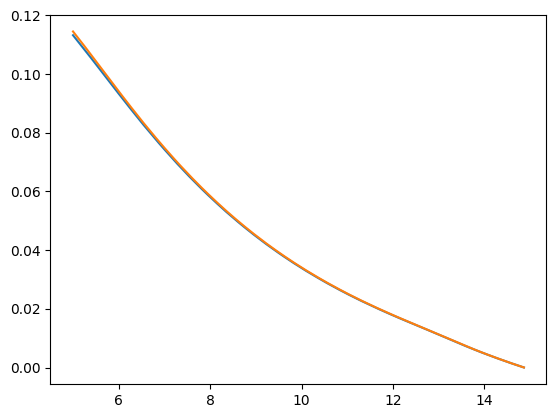

In [166]:
plt.plot(Ks,r_su)
plt.plot(Ks,r_su_l)

In [131]:
m = 6
O_0 = -1

In [132]:
X = np.linspace((0.01),(20),num=3)
get_FX_Rld(X,5,0)

(array([0.00626649, 0.92372809, 0.98778905]),
 array([-0.00518042, -0.01608965, -0.00276839]),
 array([0.00108607, 0.90763844, 0.98502066]))

In [133]:
F_RMd,F_RMu,F_R0d,F_R0u = Make_R_function(m,1.2,K_max=20)

In [134]:
F_RMd2,F_RMu2,F_R0d2,F_R0u2 = Make_R_function(m,0,K_max=20)


<Axes: xlabel='K,m'>

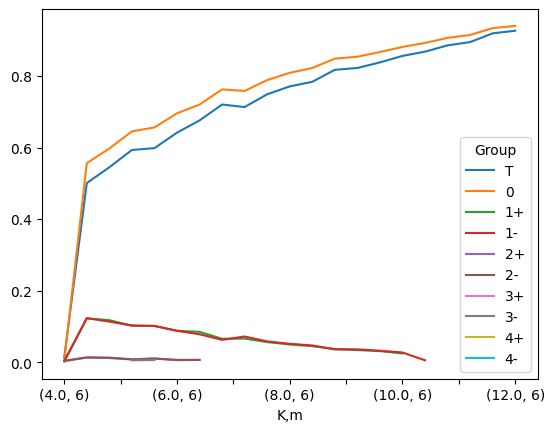

In [135]:
df['R_mean'].plot()

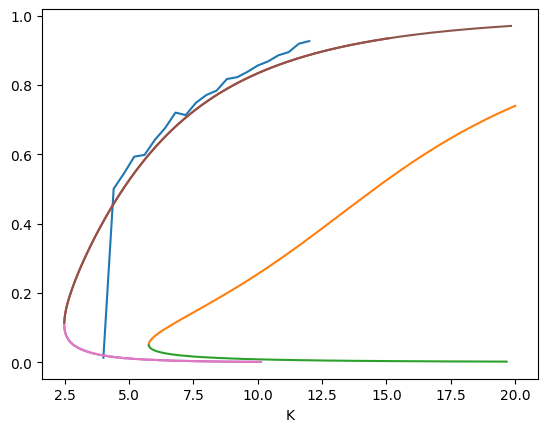

In [141]:
df_R = df['R_mean'].query('m==6').reset_index().set_index('K')['T']
Ks = np.linspace(0,20,10000)
df_R.plot()
plt.plot(Ks,F_RMu(Ks))
plt.plot(Ks,F_RMd(Ks))
plt.plot(Ks,O_RMu(Ks))
plt.plot(Ks,O_RMd(Ks))

plt.plot(Ks,F_RMu2(Ks))
plt.plot(Ks,F_RMd2(Ks))




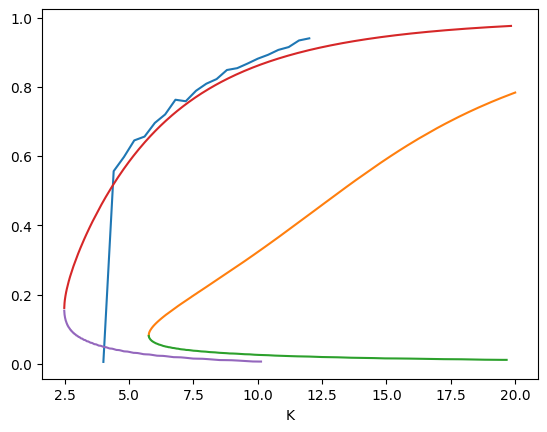

In [138]:
df_R = df['R_mean'].query('m==6').reset_index().set_index('K')['0']
Ks = np.linspace(0,20,10000)
df_R.plot()
plt.plot(Ks,F_R0u(Ks))
plt.plot(Ks,F_R0d(Ks))
plt.plot(Ks,F_R0u2(Ks))
plt.plot(Ks,F_R0d2(Ks))




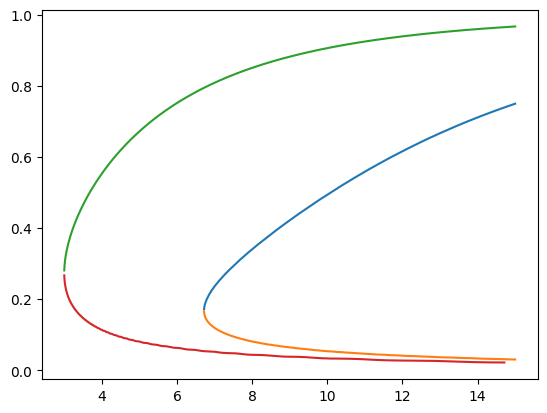

In [51]:
Ks = np.linspace(0,15,10000)
plt.plot(Ks,F_RMu(Ks))
plt.plot(Ks,F_RMd(Ks))
plt.plot(Ks,F_RMu2(Ks))
plt.plot(Ks,F_RMd2(Ks))

In [38]:
X = np.linspace((0.01),(20),num=300)
%timeit get_FX_0(X,5,0)

9.3 ms ± 237 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [63]:
X = np.linspace((0.01),(20),num=300)
%timeit get_FX_0(X,5,0)

/var/folders/lj/v2s5sd8n1cv2xdh0yw2kf0x00000gn/T/ipykernel_43166/712009942.py:42: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  I_d,err_d = quad(integrand_d,O_d,np.inf,limit=200) #drift


9.39 ms ± 299 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [55]:
FX_0(10.1,5,0)

/var/folders/lj/v2s5sd8n1cv2xdh0yw2kf0x00000gn/T/ipykernel_43166/3987189412.py:42: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  I_d,err_d = quad(integrand_d,O_d,np.inf,limit=200) #drift


(0.17978845630642337, 0.0, 0.17978845630642337)

In [53]:
FX_0(10.1,5,0)

/var/folders/lj/v2s5sd8n1cv2xdh0yw2kf0x00000gn/T/ipykernel_43166/2172296635.py:50: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  I_d,err_d = quad(integrand_d,O_d,np.inf,limit=200) #drift


(0.17978845630647494, 0.0, 0.17978845630647494)

In [49]:
%timeit FX_0(10.1,5,0)

/var/folders/lj/v2s5sd8n1cv2xdh0yw2kf0x00000gn/T/ipykernel_43166/3987189412.py:42: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  I_d,err_d = quad(integrand_d,O_d,np.inf,limit=200) #drift


32 µs ± 3.04 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [51]:
%timeit FX_0(10.1,5,0)

/var/folders/lj/v2s5sd8n1cv2xdh0yw2kf0x00000gn/T/ipykernel_43166/2172296635.py:50: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  I_d,err_d = quad(integrand_d,O_d,np.inf,limit=200) #drift


8.58 ms ± 824 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [41]:
%timeit FX_lock1(10.1,5)

4.88 µs ± 90.5 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [44]:
%timeit FX_lock1(10.1,5)

533 µs ± 43 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [136]:
FX_lock1(1,6)

TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Untyped global name 'quad': Cannot determine Numba type of <class 'function'>

File "../../../../../var/folders/lj/v2s5sd8n1cv2xdh0yw2kf0x00000gn/T/ipykernel_70806/3274474676.py", line 15:
<source missing, REPL/exec in use?> 

This error may have been caused by the following argument(s):
- argument 2: Cannot determine Numba type of <class 'function'>


In [18]:
import numpy as np
from numba import jit

@jit(nopython=True)
def trapezoidal_rule(func, a, b, n):
    h = (b - a) / n
    integral = 0.5 * (func(a) + func(b))
    for i in range(1, n):
        integral += func(a + i * h)
    integral *= h
    return integral

# 예시 함수
@jit(nopython=True)
def example_func(x):
    return np.sin(x)

# 적분 구간
a, b = 0, np.pi

# 구간을 나누는 점의 수
n = 100000

# 적분 결과
%timeit result = trapezoidal_rule(example_func, a, b, n)
print("적분 결과:", result)

337 µs ± 35.4 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
적분 결과: 1.9999999998354792


In [19]:
%timeit quad(example_func,a,b)

5.01 µs ± 149 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [20]:
quad(example_func,a,b)

(2.0, 2.220446049250313e-14)